# Param Opt w/ XGBoost and H20:

## Load the Training & Validation Sets:

In [1]:
#Load Training and Validation sets:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_validate
import csv
import sys
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import gc

In [2]:
trainBench = pd.read_csv("c:/Benchmarking/trainBench.csv")
#testBench = pd.read_csv("c:/Benchmarking/testBench.csv")
validBench = pd.read_csv("c:/Benchmarking/validBench.csv")

SplitPoint=len(trainBench.index) #SplitPoint = trainBench.shape[0] #trainBench.count(axis=0)
print("SplitPoint: ",SplitPoint)

df = pd.concat([trainBench,validBench],axis=0)
del trainBench, validBench
gc.collect()

df = df.drop("ID", axis=1)
Int64columns = df.select_dtypes(['int64']).columns
#Int64columns
df[Int64columns] = df[Int64columns].astype(np.int32)
#df['Date']=pd.to_datetime(dict(year=df['Year'], month=df['Month (number)'], day=df['Day of month']))
#numerical enconde Assortment type & Store Type
cat_columns = df.select_dtypes(['object']).columns
df[cat_columns] = df[cat_columns].astype('category')
#print("Categorical Columns:")
#print(df.select_dtypes(['category']).columns)
#print(" ")
#print(" ")
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

#print("Categorical Columns:")
#print(df.select_dtypes(['category']).columns)
#print(" ")
#print(" ")

trainBench, validBench = df.iloc[:SplitPoint, :], df.iloc[SplitPoint:, :]
print("Training Set shape",trainBench.shape)
print("Validation Set shape",validBench.shape)
del df
gc.collect()

print(" ")
print(" ")
print("Train Data Type Descriptions:")
TrainDataTypes=trainBench.dtypes
#print(TrainDataTypes)
print(trainBench.info())
print(" ")
print(" ")
#print(validBench.info())

# Split Features and Responses
mask = trainBench.columns.difference(['NumberOfSales'])
trainDataset_X = trainBench[mask]
#print(" ")
#print(" ")
print("Feature Columns:")
print(mask)
trainDataset_y = pd.DataFrame(trainBench['NumberOfSales'])
#print("Head of Validation Data:")
#print(validBench.head(3))
#print(" ")
#print(mask)
validBench_X = validBench[mask]
validBench_y = pd.DataFrame(validBench['NumberOfSales'])
#CatCols=[trainBench.columns.get_loc(c) for c in trainBench.select_dtypes(['category']).columns if c in trainBench]
del trainBench, validBench
gc
import platform
import sys
OpSys=platform.system()[:3]
print(OpSys)
OpSysVer=platform.release()
print(OpSysVer)
LangVer=sys.version[:5]
print(LangVer)
import sklearn
Lib='sklearn'
print(Lib)
LibVer= sklearn.__version__
print(LibVer)

from openpyxl import load_workbook
workbook_name = 'C:\\Benchmarking\\AlgoPerf.xlsx'
def xlsADD(row):
    wb = load_workbook(workbook_name)
    page = wb.active
    page.append(row)
    wb.save(filename=workbook_name) 

def InsertHeader():
    Result=('OpSys','OpVer', 
            'Lang', 
            'LangVer', 
            'Lib', 
            'Lib.Ver', 
            'Algo',
            'M_FitTime', 
            'XVR_FitTime',
            'XVR_ScorTime',
            'XV_Time',
            'XV_EV',
            'XV_MAE', 
            'XV_MSE', 
            'XV_RMSE', 
            'XV_R2',
            'TS_PredTime',
            'TS_EV',
            'TS_MAE', 
            'TS_MSE', 
            'TS_RMSE', 
            'TS_R2',
            'MeanEV',
            'MdlParam', 
            'FeatImp',
            'TdTypes',
            'Comments')
    #print(Result)
    xlsADD(Result)
    
def InsertValues():
    Result=(OpSys, 
            OpSysVer, 
            'Python', 
            LangVer, 
            Lib, 
            LibVer,
            Algo,
            M_FitTime, 
            XVR_FT,
            ST,
            XValidTime,
            EV,
            MAE, 
            MSE, 
            RMSE, 
            R2,
            PredTime,
            EVv,
            MAEv, 
            MSEv, 
            RMSEv, 
            R2v,
            EVtot.mean(),
            str(Params), 
            str(d),
            str(TrainDataTypes),
            Comments)
    #print(Result)
    xlsADD(Result)

SplitPoint:  100553
Training Set shape (100553, 18)
Validation Set shape (20405, 18)
 
 
Train Data Type Descriptions:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100553 entries, 0 to 100552
Data columns (total 18 columns):
StoreID                 100553 non-null int32
IsHoliday               100553 non-null int32
IsOpen                  100553 non-null int32
HasPromotions           100553 non-null int32
StoreType               100553 non-null int8
AssortmentType          100553 non-null int8
NearestCompetitor       100553 non-null int32
Region                  100553 non-null int32
NumberOfSales           100553 non-null int32
Region_AreaKM2          100553 non-null int32
Region_GDP              100553 non-null int32
Region_PopulationK      100553 non-null int32
Year                    100553 non-null int32
Month (number)          100553 non-null int32
Week                    100553 non-null int32
Day of year             100553 non-null int32
Day of month            100553 non-n

## Cross Validate and Score

In [4]:
#Cross Validate and Score 1
params={}
def CrossEval(SplitPercent=20, MdlParams={}, verbose=False):
    #**************Insert comments about this run here:
    global Comments
    #Comments='n_estimators=250, max_features=n_features-15, max_depth = 15, '+ str(SplitPercent)+'% of the training data'
    global Algo
    Algo='ExtraTreesRegressor'
    Nrows,Ncols=trainDataset_X.shape
    SplitPoint=int(Nrows*(SplitPercent/100))
    X, y = trainDataset_X.iloc[:SplitPoint, :], trainDataset_y.iloc[:SplitPoint]
    #if verbose: 
    print("Training data set shape:",X.shape)
    start=time.time()
    forest = ExtraTreesRegressor(n_estimators=240, 
                                 max_features = int(X.columns.size - 15),
                                 max_depth = 16,
                                 n_jobs=-1, 
                                 random_state=0)
    if MdlParams != {}:
        forest.set_params(**MdlParams)
    
    forest.fit(X, y)
    global M_FitTime, XValidTime, PredTime
    M_FitTime = time.time() - start
    if verbose:print("Measured Fit Time: ", M_FitTime)

    UseTScv=True
    if UseTScv:
        from sklearn.model_selection import TimeSeriesSplit
        if verbose:print("Using Time Series Cross Validation")
        start=time.time()
        tscv = TimeSeriesSplit(n_splits=5)
        scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=tscv, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )        
    else:
        from sklearn.model_selection import KFold
        if verbose:print("Using KFold Cross Validation")
        start=time.time()
        kfolds = KFold(n_splits=5,shuffle=False,random_state=0)
        scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=kfolds, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )

    XValidTime = time.time() - start

    if verbose:print(" ")
    if verbose:print("Model Parameters: ")
    global Params
    Params=forest.get_params(deep=True)
    if verbose:print(Params)
    if verbose:print(" "); 
    global EV, MAE, MSE, RMSE, R2,XVR_FT, ST 
    if verbose:print("Cross Validation Performance: ")
    #if verbose:
    print("Cross Validation Time: %0.6f" % (XValidTime))
    EV=scores['test_explained_variance'].mean()
    if verbose:print(scores['test_explained_variance'])
    if verbose:print("EV: %0.6f" % (EV))
    #MAE is less sensitive to outliers, The contant value that minimizes the MAE is the median of the target values
    if verbose:print(-1*scores['test_neg_mean_absolute_error'])
    MAE=-1*scores['test_neg_mean_absolute_error'].mean()
    if verbose:print("MAE: %0.6f" % (MAE))
    #MAE considers outliers, The contant value that minimizes the MSE is the mean of the target values
    #If you think your outliers are erros in the data use MAE, if you think the outliers are true datapoints use MSE.
    #It is easier to optmize MSE than RMSE because RMSE requires an adjustable learning rate.
    if verbose:print(-1*scores['test_neg_mean_squared_error'])
    MSE=-1*scores['test_neg_mean_squared_error'].mean()
    if verbose:print("MSE: %0.6f" % (MSE))
    if verbose:print(np.sqrt(-1*scores['test_neg_mean_squared_error']))
    RMSE=np.sqrt(-1*scores['test_neg_mean_squared_error'].mean())
    if verbose:print("RMSE: %0.6f" % (RMSE))
    #Optimizing R2 and optimizing for MSE is the same, since R2 = 1-(MSE/Constant)
    if verbose:print("XV R2 Actuals:",scores['test_r2'])
    R2=scores['test_r2'].mean()
    if verbose:print("Cross Validation R2: %0.6f" % (R2))
    if verbose:print("XVR_fit_time Actuals: ", (scores['fit_time']))
    XVR_FT=scores['fit_time'].mean()
    if verbose:print("XVR_fit_time: %0.6f" % (XVR_FT))
    if verbose:print("score_time Actuals: ", (scores['score_time']))      
    ST=scores['score_time'].mean()
    if verbose:print("score_time: %0.6f" % (ST))

    Comments=str(Params)
    
    # Score Validation Set: 
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import r2_score

    start=time.time()
    y_pred=forest.predict(validBench_X)
    PredTime = time.time() - start

    if verbose:print(" ")
    if verbose:print(" ")
    global EVv, MAEv, MSEv, RMSEv, R2v, EVtot
    if verbose:print("Prediction Time: ", PredTime)
    if verbose:print(" ")
    if verbose:print("Validation data set shape:",validBench_X.shape)
    EVv=explained_variance_score(validBench_y, y_pred)
    if verbose:print("Validation Set Explained Variance (EV): %0.2f" % (EVv))
    #MAE is less sensitive to outliers, The constant value that minimizes the MAE is the median of the target values
    MAEv=mean_absolute_error(validBench_y, y_pred)
    if verbose:print("MAE: %0.6f" % (MAEv))
    #MAE considers outliers, The contant value that minimizes the MSE is the mean of the target values
    #If you think your outliers are erros in the data use MAE, if you think the outliers are true datapoints use MSE.
    #It is easier to optmize MSE than RMSE because RMSE requires an adjustable learning rate.
    MSEv=mean_squared_error(validBench_y, y_pred)
    if verbose:print("MSE: %0.6f" % (MSEv))
    RMSEv=np.sqrt(MSEv)
    if verbose:print("RMSE: %0.6f" % (RMSEv))
    #Optimizing R2 and optimizing for MSE is the same, since R2 = 1-(MSE/Constant)
    R2v=r2_score(validBench_y, y_pred)
    if verbose:print("Validation Set R2: %0.6f" % (R2v))
    EVtot=scores['test_explained_variance'].copy()
    EVtot = np.append(EVtot,EVv)
    EVtotMean=EVtot.mean()
    if verbose:print("Total Mean EV: ",EVtot,EVtotMean)
    
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    if verbose:print(" ")
    if verbose:print(" ")
    if verbose:print("Feature Importances:")
    global d
    d=[]
    
    for f in range(X.shape[1]):
        if verbose:print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))
        d.append({"%d. feat: %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]])})
    if verbose:print(" ")
    if verbose:print("Validation Set EV, XVal EV, Mean EV: ",EVv, EV, EVtotMean)
    #InsertHeader()
    #InsertValues()
    return EVv, EV, EVtotMean

In [11]:
#Cross Validate and Score 2: Can pass the model as a parameter
params={}
def CrossEval2(SplitPercent=20, Mdl=ExtraTreesRegressor(), MdlParams={}, verbose=False, AlgName=""):
    #**************Insert comments about this run here:
    global Comments
    #Comments='n_estimators=250, max_features=n_features-15, max_depth = 15, '+ str(SplitPercent)+'% of the training data'
    global Algo
    if AlgName !="":
        Algo=AlgName
    else:
        Algo= type(Mdl).__name__
    print("Current Model: ", Algo)
    if verbose: print("Current Model: ", Algo)
    Nrows,Ncols=trainDataset_X.shape
    SplitPoint=int(Nrows*(SplitPercent/100))
    X, y = trainDataset_X.iloc[:SplitPoint, :], trainDataset_y.iloc[:SplitPoint]
    #if verbose: 
    print("Training data set shape:",X.shape)
    start=time.time()
    
    forest = Mdl
    
    if MdlParams != {}:
        forest.set_params(**MdlParams)
    else:
        forest.set_params(n_estimators=240, 
                          max_features = int(X.columns.size - 15),
                          max_depth = 16,
                          n_jobs=-1, 
                          random_state=0)
    
    forest.fit(X, y)
    global M_FitTime, XValidTime, PredTime
    M_FitTime = time.time() - start
    if verbose:print("Measured Fit Time: ", M_FitTime)

    UseTScv=True
    if UseTScv:
        from sklearn.model_selection import TimeSeriesSplit
        if verbose:print("Using Time Series Cross Validation")
        start=time.time()
        tscv = TimeSeriesSplit(n_splits=5)
        scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=tscv, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )        
    else:
        from sklearn.model_selection import KFold
        if verbose:print("Using KFold Cross Validation")
        start=time.time()
        kfolds = KFold(n_splits=5,shuffle=False,random_state=0)
        scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=kfolds, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )

    XValidTime = time.time() - start

    if verbose:print(" ")
    if verbose:print("Model Parameters: ")
    global Params
    Params=forest.get_params(deep=True)
    if verbose:print(Params)
    if verbose:print(" "); 
    global EV, MAE, MSE, RMSE, R2,XVR_FT, ST 
    if verbose:print("Cross Validation Performance: ")
    #if verbose:
    print("Cross Validation Time: %0.6f" % (XValidTime))
    EV=scores['test_explained_variance'].mean()
    if verbose:print(scores['test_explained_variance'])
    if verbose:print("EV: %0.6f" % (EV))
    #MAE is less sensitive to outliers, The contant value that minimizes the MAE is the median of the target values
    if verbose:print(-1*scores['test_neg_mean_absolute_error'])
    MAE=-1*scores['test_neg_mean_absolute_error'].mean()
    if verbose:print("MAE: %0.6f" % (MAE))
    #MAE considers outliers, The contant value that minimizes the MSE is the mean of the target values
    #If you think your outliers are erros in the data use MAE, if you think the outliers are true datapoints use MSE.
    #It is easier to optmize MSE than RMSE because RMSE requires an adjustable learning rate.
    if verbose:print(-1*scores['test_neg_mean_squared_error'])
    MSE=-1*scores['test_neg_mean_squared_error'].mean()
    if verbose:print("MSE: %0.6f" % (MSE))
    if verbose:print(np.sqrt(-1*scores['test_neg_mean_squared_error']))
    RMSE=np.sqrt(-1*scores['test_neg_mean_squared_error'].mean())
    if verbose:print("RMSE: %0.6f" % (RMSE))
    #Optimizing R2 and optimizing for MSE is the same, since R2 = 1-(MSE/Constant)
    if verbose:print("XV R2 Actuals:",scores['test_r2'])
    R2=scores['test_r2'].mean()
    if verbose:print("Cross Validation R2: %0.6f" % (R2))
    if verbose:print("XVR_fit_time Actuals: ", (scores['fit_time']))
    XVR_FT=scores['fit_time'].mean()
    if verbose:print("XVR_fit_time: %0.6f" % (XVR_FT))
    if verbose:print("score_time Actuals: ", (scores['score_time']))      
    ST=scores['score_time'].mean()
    if verbose:print("score_time: %0.6f" % (ST))

    Comments=str(Params)
    
    # Score Validation Set: 
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import r2_score

    start=time.time()
    y_pred=forest.predict(validBench_X)
    PredTime = time.time() - start

    if verbose:print(" ")
    if verbose:print(" ")
    global EVv, MAEv, MSEv, RMSEv, R2v, EVtot
    if verbose:print("Prediction Time: ", PredTime)
    if verbose:print(" ")
    if verbose:print("Validation data set shape:",validBench_X.shape)
    EVv=explained_variance_score(validBench_y, y_pred)
    if verbose:print("Validation Set Explained Variance (EV): %0.2f" % (EVv))
    #MAE is less sensitive to outliers, The constant value that minimizes the MAE is the median of the target values
    MAEv=mean_absolute_error(validBench_y, y_pred)
    if verbose:print("MAE: %0.6f" % (MAEv))
    #MAE considers outliers, The contant value that minimizes the MSE is the mean of the target values
    #If you think your outliers are erros in the data use MAE, if you think the outliers are true datapoints use MSE.
    #It is easier to optmize MSE than RMSE because RMSE requires an adjustable learning rate.
    MSEv=mean_squared_error(validBench_y, y_pred)
    if verbose:print("MSE: %0.6f" % (MSEv))
    RMSEv=np.sqrt(MSEv)
    if verbose:print("RMSE: %0.6f" % (RMSEv))
    #Optimizing R2 and optimizing for MSE is the same, since R2 = 1-(MSE/Constant)
    R2v=r2_score(validBench_y, y_pred)
    if verbose:print("Validation Set R2: %0.6f" % (R2v))
    EVtot=scores['test_explained_variance'].copy()
    EVtot = np.append(EVtot,EVv)
    EVtotMean=EVtot.mean()
    if verbose:print("Total Mean EV: ",EVtot,EVtotMean)
    
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    if verbose:print(" ")
    if verbose:print(" ")
    if verbose:print("Feature Importances:")
    global d
    d=[]
    
    for f in range(X.shape[1]):
        if verbose:print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))
        d.append({"%d. feat: %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]])})
    if verbose:print(" ")
    if verbose:print("Validation Set EV, XVal EV, Mean EV: ",EVv, EV, EVtotMean)
    #InsertHeader()
    #InsertValues()
    return EVv, EV, EVtotMean

In [14]:
#CrossEval2 Test:
from sklearn.ensemble import RandomForestRegressor
MdlParams={}
Mdl=ExtraTreesRegressor
CrossEval2(100, Mdl=Mdl, MdlParams=MdlParams,verbose=True,)

Current Model:  ExtraTreesRegressor
Training data set shape: (100553, 17)
Measured Fit Time:  3.0296638011932373
Using Time Series Cross Validation
 
Model Parameters: 
{'bootstrap': False, 'criterion': 'mse', 'max_depth': 16, 'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 240, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
 
Cross Validation Performance: 
Cross Validation Time: 26.107286
[0.6893979  0.55408824 0.64868223 0.67215276 0.39283517]
EV: 0.591431
[ 965.77104548 1290.12103312 1130.37150079 1032.344633   1251.99564222]
MAE: 1134.120771
[2031006.19284856 3981787.24555979 2449460.21873086 2362433.8414521
 6041839.27572217]
MSE: 3373305.354863
[1425.1337456  1995.44161668 1565.07514795 1537.02109337 2458.01531234]
RMSE: 1836.656025
XV R2 Actuals: [0.66915499 0.55369165 0.64824639 0.67212614 0

(0.6803452671668492, 0.5914312586047856, 0.6062502600317962)

In [17]:
#Cross Validate and Score 3
params={}
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb

def CrossEval3(trainDataset_X, trainDataset_y,
               validBench_X, validBench_y,
               SplitPercent=100, Mdl=ExtraTreesRegressor, MdlParams={}, verbose=False,
               AlgName="", Comment=""):
    global Algo
    if AlgName !="":
        Algo=AlgName
    else:
        Algo= type(Mdl).__name__
    print("Current Model: ", Algo)
    Nrows,_ =trainDataset_X.shape
    SplitPoint=int(Nrows*(SplitPercent/100))
    #print(SplitPoint)
    Pandas = False
    if isinstance(trainDataset_X,pd.core.frame.DataFrame): Pandas=True
    print("Pandas Value:",Pandas)
    if Pandas:
        X, y = trainDataset_X.iloc[:SplitPoint, :], trainDataset_y.iloc[:SplitPoint]
    elif isinstance(trainDataset_X,h2o.H2OFrame):
        X, y = trainDataset_X[:SplitPoint, :], trainDataset_y[:SplitPoint, :]
        X=X.concat(y, axis=1)
        print("Y column: ",y.names)
        print("X columns: ",X.names)
    del(trainDataset_X,trainDataset_y)
    
    #if verbose: 
    print("Training data set shape:",X.shape)
    
    forest = Mdl
    
    if MdlParams != {}:
        forest.set_params(**MdlParams)
    elif Pandas:
        forest.set_params(n_estimators=245, 
                          max_features = int(X.columns.size - 15),
                          max_depth = 16,
                          n_jobs=-1, 
                          random_state=0)
    #print(X.shape,y.shape)
    
    global M_FitTime, XValidTime, PredTime
    global EV, MAE, MSE, RMSE, R2, XVR_FT, ST 
    
    EVar=[]; MAEar=[]; MSEar=[]; R2ar=[]; RMSEar=[]
    
    start=time.time()
    if Pandas: 
        y=y.values.ravel()
        forest.fit(X, y)
        M_FitTime = time.time() - start
        UseTScv=True
        start=time.time()
        if UseTScv:
            if verbose:print("Using Time Series Cross Validation")
            tscv = TimeSeriesSplit(n_splits=5)
            scores = cross_validate(forest, X, y, cv=tscv, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )        
        else:
            if verbose:print("Using KFold Cross Validation")
            kfolds = KFold(n_splits=5,shuffle=False,random_state=0)
            scores = cross_validate(forest, X, y, cv=kfolds, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )
        XValidTime = time.time() - start
        EVar=scores['test_explained_variance']
        MAEar=-1*scores['test_neg_mean_absolute_error']
        MSEar=-1*scores['test_neg_mean_squared_error']
        RMSEar=np.sqrt(-1*scores['test_neg_mean_squared_error'])
        R2ar=scores['test_r2']
        XVR_FTar=scores['fit_time']
        STar=scores['score_time']
    else: #For H2O you have to do time series cross validation manually
        forest.set_params(nfolds=0)
        M_FitTime=0
        start=time.time()        
        tscv = TimeSeriesSplit(n_splits=5)

        Xcols=list(set(X.names)-set('NumberOfSales'))
        Ycol='NumberOfSales'
        for train_index, test_index in tscv.split(X):
            #print("TRAIN:", train_index, "TEST:", test_index)
            train = X[min(train_index):max(train_index),:]
            test = X[min(test_index):max(test_index),:]
            print(len(train),len(test))
            forest.train(x=Xcols,y=Ycol,
                         training_frame=train,validation_frame=test,verbose=False)            
            y_pred=forest.predict(test[Xcols])
            EVar.append(explained_variance_score(test[Ycol].as_data_frame(), y_pred.as_data_frame()))
            MAEar.append(mean_absolute_error(test[Ycol].as_data_frame(), y_pred.as_data_frame()))
            MSEar.append(mean_squared_error(test[Ycol].as_data_frame(), y_pred.as_data_frame()))
            R2ar.append(r2_score(test[Ycol].as_data_frame(), y_pred.as_data_frame()))
        
        df = pd.DataFrame(forest.get_params())
        print(df)
        RMSEar=np.sqrt(np.array(MSEar))
        XVR_FTar=[0, 0, 0, 0, 0]
        STar=[0, 0, 0, 0, 0]
        XValidTime = time.time() - start 
    
    EV = np.array(EVar).mean()
    MAE=np.array(MAEar).mean()
    MSE=np.array(MSEar).mean()
    RMSE=np.array(RMSEar).mean()
    R2=np.array(R2ar).mean()
    XVR_FT=np.array(XVR_FTar).sum()
    ST=np.array(STar).sum()
    
    if verbose:print("Measured Fit Time: ", M_FitTime)
        
    if verbose:print(" ")

    global Params
    Params=forest.get_params(deep=True)
    if verbose and Pandas:
        print("Model Parameters: ")
        print(Params)
    if verbose:print(" "); 

    if verbose:print("Cross Validation Performance: ")
    print("Cross Validation Time: %0.6f" % (XValidTime))
    if verbose:print("EV: %0.6f" % (EV))
    if verbose:print("EV for each Fold:",EVar)
    #MAE is less sensitive to outliers, The contant value that minimizes the MAE is the median of the target values
    if verbose:print("MAE: %0.6f" % (MAE))
    if verbose:print("MAE for each Fold:",MAEar)
    #MAE considers outliers, The contant value that minimizes the MSE is the mean of the target values
    #If you think your outliers are erros in the data use MAE, if you think the outliers are true datapoints use MSE.
    #It is easier to optmize MSE than RMSE because RMSE requires an adjustable learning rate.
    if verbose:print("MSE: %0.6f" % (MSE))
    if verbose:print("MSE for each Fold:",MSEar)
    if verbose:print("RMSE: %0.6f" % (RMSE))
    if verbose:print("RMSE for each Fold:",RMSEar)
    #Optimizing R2 and optimizing for MSE is the same, since R2 = 1-(MSE/Constant)
    if verbose:print("XV R2 Actuals:",R2ar)
    if verbose:print("Cross Validation R2: %0.6f" % (R2))
    if verbose:print("XVR_fit_time Actuals: ", (XVR_FTar))
    if verbose:print("XVR_fit_time: %0.6f" % (XVR_FT))
    if verbose:print("score_time Actuals: ", (STar))      
    if verbose:print("score_time: %0.6f" % (ST))

    
    
    #**************Insert comments about this run here:
    global Comments    
    if Comment=="":
        Comments=str(Params)
    else:
        Comments=Comment
    #Comments='n_estimators=250, max_features=n_features-15, max_depth = 15, '+ str(SplitPercent)+'% of the training data'
        
    # Score Validation Set: 
    start=time.time()
    if Pandas:
        y_pred=forest.predict(validBench_X)
    else:
        y_pred=forest.predict(validBench_X).as_data_frame()
        validBench_y=validBench_y.as_data_frame()
    PredTime = time.time() - start

    if verbose:print(" ")
    if verbose:print(" ")
    global EVv, MAEv, MSEv, RMSEv, R2v, EVtot
    if verbose:print("Prediction Time: ", PredTime)
    if verbose:print(" ")
    if verbose:print("Validation data set shape:",validBench_X.shape)
    EVv=explained_variance_score(validBench_y, y_pred)
    if verbose:print("Validation Set Explained Variance (EV): %0.2f" % (EVv))
    #MAE is less sensitive to outliers, The constant value that minimizes the MAE is the median of the target values
    MAEv=mean_absolute_error(validBench_y, y_pred)
    if verbose:print("MAE: %0.6f" % (MAEv))
    #MAE considers outliers, The constant value that minimizes the MSE is the mean of the target values
    #If you think your outliers are erros in the data use MAE, if you think the outliers are true datapoints use MSE.
    #It is easier to optmize MSE than RMSE because RMSE requires an adjustable learning rate.
    MSEv=mean_squared_error(validBench_y, y_pred)
    if verbose:print("MSE: %0.6f" % (MSEv))
    RMSEv=np.sqrt(MSEv)
    if verbose:print("RMSE: %0.6f" % (RMSEv))
    #Optimizing R2 and optimizing for MSE is the same, since R2 = 1-(MSE/Constant)
    R2v=r2_score(validBench_y, y_pred)
    if verbose:print("Validation Set R2: %0.6f" % (R2v))
    EVtot=EVar.copy()
    EVtot = np.append(EVtot,EVv)
    EVtotMean=EVtot.mean()
    if verbose:print("Total Mean EV: ",EVtot,EVtotMean)
    global d
    if Pandas and Algo!="XGBRegressor":
        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                     axis=0)
        indices = np.argsort(importances)[::-1]

        # Print the feature ranking
        if verbose:print(" ")
        if verbose:print(" ")
        if verbose:print("Feature Importances:")

        d=[]

        for f in range(X.shape[1]):
            if verbose:print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))
            d.append({"%d. feat: %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]])})
        if verbose:print(" ")
    else:
        d=""
    if verbose:print("Validation Set EV, XVal EV, Mean EV: ",EVv, EV, EVtotMean)

    #InsertHeader()
    InsertValues()
    return EVv, EV, EVtotMean, R2v, R2, -MAE, -MAEv 

## CrossEval3 Test with XGBRegressor:

In [39]:
#CrossEval3 Test:
from sklearn.ensemble import RandomForestRegressor
MdlParams= {'max_depth': 11, 'n_estimators': 53, 'learning_rate': 0.097, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'subsample': 1, 'reg_lambda': 5}

Mdl=xgb.XGBRegressor(random_state=0,n_jobs=-1,)
CrossEval3(trainDataset_X,trainDataset_y,validBench_X,validBench_y,
           SplitPercent=100, Mdl=Mdl, MdlParams=MdlParams,verbose=True,AlgName="XGBRegressor",
           Comment="Best Params found Maximazing Avg. EV")

Current Model:  XGBRegressor
Pandas Value: True
Training data set shape: (100553, 17)
Using Time Series Cross Validation
Measured Fit Time:  7.624358177185059
 
Model Parameters: 
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.097, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 53, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 5, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
 
Cross Validation Performance: 
Cross Validation Time: 14.588277
EV: 0.623928
EV for each Fold: [0.68190691 0.56076369 0.67496651 0.65102564 0.55097968]
MAE: 1170.456117
MAE for each Fold: [1058.7341904  1298.82717459 1154.30082154 1081.80776398 1258.61063623]
MSE: 3138426.957409
MSE for each Fold: [2331326.57835202 3923153.33696417 2329060.63802474 2517511.5149839
 4591082.71871968]
RMSE: 1752.607481
RMSE for ea

(0.6855958186900012,
 0.6239284875611242,
 0.6342063760826037,
 0.6781513177647969,
 0.6070106735659544,
 -1170.4561173464306,
 -1000.3753948798661)

In [18]:
#{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 
#'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3.0, 'min_child_weight': 1, 'missing': None, 
#'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0,
#'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}

#23        6,           54,           0.101,              0.5,   0.5  -1014
#{'max_depth': 8, 'n_estimators': 57, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 0.1}
#28        10,          53,           0.098,              1,     0.5,  0 score:0.634091
#0.634091: {'max_depth': 10.0, 'n_estimators': 53.0, 'learning_rate': 0.098, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.5, 'subsample': 1.0}

param_dist={'max_depth':[10,11,12],
            'n_estimators': [51,52,53,54,57,58],
            'learning_rate': [0.097,0.098, 0.099,0.1,0.101],
            'colsample_bylevel': [0.99,1],
            'colsample_bytree': [0.5,0.55,1],
            'subsample': [0.8,0.9,1],
            'reg_lambda':[0.1,0.5,1,1.1,1.5,2,5]
           } 

Mdl=xgb.XGBRegressor(random_state=0, n_jobs=-1)
PatternSearch(param_dist, 100, Mdl=Mdl, alfa=1.40, metric=2, verbose=False)


max_depth : [10, 11, 12]
n_estimators : [51, 52, 53, 54, 57, 58]
learning_rate : [0.097, 0.098, 0.099, 0.1, 0.101]
colsample_bylevel : [0.99, 1]
colsample_bytree : [0.5, 0.55, 1]
subsample : [0.8, 0.9, 1]
reg_lambda : [0.1, 0.5, 1, 1.1, 1.5, 2, 5]
{'max_depth': 11, 'n_estimators': 53, 'learning_rate': 0.099, 'colsample_bylevel': 0.99, 'colsample_bytree': 0.55, 'subsample': 0.9, 'reg_lambda': 1.1}
Current Model:  XGBRegressor
Pandas Value: True
Training data set shape: (100553, 17)
Cross Validation Time: 18.162286
   max_depth  n_estimators  learning_rate  colsample_bylevel  \
0       11.0          53.0          0.099               0.99   

   colsample_bytree  subsample  reg_lambda     score  
0              0.55        0.9         1.1  0.605803  
1 {'max_depth': 12, 'n_estimators': 53, 'learning_rate': 0.099, 'colsample_bylevel': 0.99, 'colsample_bytree': 0.55, 'subsample': 0.9, 'reg_lambda': 1.1}
Current Model:  XGBRegressor
Pandas Value: True
Training data set shape: (100553, 17)
Cr

Cross Validation Time: 15.299230
   max_depth  n_estimators  learning_rate  colsample_bylevel  \
0       11.0          53.0          0.099               0.99   
1       12.0          53.0          0.099               0.99   
2       12.0          58.0          0.099               0.99   
3       12.0          51.0          0.099               0.99   
4       12.0          51.0          0.101               0.99   
5       12.0          51.0          0.097               0.99   
6       12.0          51.0          0.097               1.00   
7       12.0          51.0          0.097               1.00   
8       12.0          51.0          0.097               1.00   
9       12.0          51.0          0.097               1.00   

   colsample_bytree  subsample  reg_lambda     score  
0              0.55        0.9         1.1  0.605803  
1              0.55        0.9         1.1  0.614355  
2              0.55        0.9         1.1  0.614221  
3              0.55        0.9         1.1

Cross Validation Time: 13.726425
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0        11.0          53.0          0.099               0.99   
1        12.0          53.0          0.099               0.99   
2        12.0          58.0          0.099               0.99   
3        12.0          51.0          0.099               0.99   
4        12.0          51.0          0.101               0.99   
5        12.0          51.0          0.097               0.99   
6        12.0          51.0          0.097               1.00   
7        12.0          51.0          0.097               1.00   
8        12.0          51.0          0.097               1.00   
9        12.0          51.0          0.097               1.00   
10       12.0          51.0          0.097               1.00   
11       11.0          51.0          0.097               1.00   
12       11.0          53.0          0.097               1.00   
13       11.0          53.0          0.098               

Cross Validation Time: 16.292429
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0        11.0          53.0          0.099               0.99   
1        12.0          53.0          0.099               0.99   
2        12.0          58.0          0.099               0.99   
3        12.0          51.0          0.099               0.99   
4        12.0          51.0          0.101               0.99   
5        12.0          51.0          0.097               0.99   
6        12.0          51.0          0.097               1.00   
7        12.0          51.0          0.097               1.00   
8        12.0          51.0          0.097               1.00   
9        12.0          51.0          0.097               1.00   
10       12.0          51.0          0.097               1.00   
11       11.0          51.0          0.097               1.00   
12       11.0          53.0          0.097               1.00   
13       11.0          53.0          0.098               

Cross Validation Time: 14.156225
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0        11.0          53.0          0.099               0.99   
1        12.0          53.0          0.099               0.99   
2        12.0          58.0          0.099               0.99   
3        12.0          51.0          0.099               0.99   
4        12.0          51.0          0.101               0.99   
5        12.0          51.0          0.097               0.99   
6        12.0          51.0          0.097               1.00   
7        12.0          51.0          0.097               1.00   
8        12.0          51.0          0.097               1.00   
9        12.0          51.0          0.097               1.00   
10       12.0          51.0          0.097               1.00   
11       11.0          51.0          0.097               1.00   
12       11.0          53.0          0.097               1.00   
13       11.0          53.0          0.098               

,max_depth,n_estimators,learning_rate,colsample_bylevel,colsample_bytree,subsample,reg_lambda,score
12,11.0,53.0,0.097,1.00,0.50,1.0,5.0,0.634206
20,11.0,54.0,0.097,1.00,0.50,1.0,5.0,0.634158
21,11.0,52.0,0.097,1.00,0.50,1.0,5.0,0.633689
11,11.0,51.0,0.097,1.00,0.50,1.0,5.0,0.633401
13,11.0,53.0,0.098,1.00,0.50,1.0,5.0,0.633075
18,12.0,53.0,0.097,1.00,0.50,1.0,5.0,0.632831
10,12.0,51.0,0.097,1.00,0.50,1.0,5.0,0.632173
19,10.0,53.0,0.097,1.00,0.50,1.0,5.0,0.631785
22,11.0,53.0,0.097,1.00,0.50,1.0,2.0,0.631440
17,11.0,53.0,0.097,1.00,0.50,1.0,1.5,0.630788


## XGBoost Lambda (regularization parameter) Study: 

In [41]:
Lamb = [4.8,4.9,4.95,5,5.05,5.1,5.15,5.2] 

MdlParams= {'max_depth': 11, 'n_estimators': 53, 'learning_rate': 0.097, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'subsample': 1, 'reg_lambda': 4.8}
Mdl=xgb.XGBRegressor(random_state=0, n_jobs=-1)
Mdl.set_params(**MdlParams)
MdlParams={}
print(Mdl.get_params(deep=True))
for i in Lamb:
    MdlParams['reg_lambda']=i
    print("lambda: ",i)
    Comment="Regularization Study, reg_lambda = "+str(i)
    print(CrossEval3(trainDataset_X,trainDataset_y,validBench_X,validBench_y,
           SplitPercent=100, Mdl=Mdl, MdlParams=MdlParams,verbose=True,AlgName="XGBRegressor",
           Comment=Comment))

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.097, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 53, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 5, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
lambda:  4.8
Current Model:  XGBRegressor
Pandas Value: True
Training data set shape: (100553, 17)
Using Time Series Cross Validation
Measured Fit Time:  7.890299558639526
 
Model Parameters: 
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.097, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 53, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 4.8, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}

Using Time Series Cross Validation
Measured Fit Time:  4.6175007820129395
 
Model Parameters: 
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.097, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 53, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 5.05, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
 
Cross Validation Performance: 
Cross Validation Time: 14.743078
EV: 0.623211
EV for each Fold: [0.68058435 0.56028828 0.67280508 0.65401448 0.54836285]
MAE: 1165.690000
MAE for each Fold: [1060.63258729 1302.03573506 1155.90623577 1071.39002429 1238.48541597]
MSE: 3136176.972381
MSE for each Fold: [2340111.11729684 3927981.5672502  2338358.59517269 2499871.89231367
 4574561.6898692 ]
RMSE: 1752.149171
RMSE for each Fold: [1529.74217347 1981.91361246 1529.16925001 1581.09831836 2138.82250079]


In [42]:
alpha = [0,0.1,0.5,1,4.8,4.9,4.95,5,5.05,5.1,5.15,5.2,7.5,10,15] 

MdlParams= {'max_depth': 11, 'n_estimators': 53, 'learning_rate': 0.097, 'colsample_bylevel': 1,
            'colsample_bytree': 0.5, 'subsample': 1, 'reg_lambda': 4.8}
Mdl=xgb.XGBRegressor(random_state=0, n_jobs=-1)
Mdl.set_params(**MdlParams)
MdlParams={}
print(Mdl.get_params(deep=True))
for i in alpha:
    MdlParams['reg_alpha']=i
    print("lambda: ",i)
    Comment="Regularization Study, reg_alpha = "+str(i)
    print(CrossEval3(trainDataset_X,trainDataset_y,validBench_X,validBench_y,
           SplitPercent=100, Mdl=Mdl, MdlParams=MdlParams,verbose=True,AlgName="XGBRegressor",
           Comment=Comment))

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.097, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 53, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 4.8, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
lambda:  0
Current Model:  XGBRegressor
Pandas Value: True
Training data set shape: (100553, 17)
Using Time Series Cross Validation
Measured Fit Time:  6.129440546035767
 
Model Parameters: 
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.097, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 53, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 4.8, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}

Using Time Series Cross Validation
Measured Fit Time:  4.582468271255493
 
Model Parameters: 
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.097, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 53, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 4.8, 'reg_lambda': 4.8, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
 
Cross Validation Performance: 
Cross Validation Time: 14.602407
EV: 0.623548
EV for each Fold: [0.68055193 0.55340305 0.67772345 0.6511228  0.55493712]
MAE: 1167.656644
MAE for each Fold: [1056.61739841 1312.64071947 1148.87308396 1073.83087985 1246.32114002]
MSE: 3133246.494398
MSE for each Fold: [2318326.97726656 3990583.0209523  2309910.37823052 2516387.16349614
 4531024.93204326]
RMSE: 1751.004299
RMSE for each Fold: [1522.60532551 1997.64436799 1519.83893167 1586.31244195 2128.6204293 ]


(0.6848763222234637, 0.6225747235509742, 0.6329583233297225, 0.6737842826666404, 0.6067832261261662, -1169.0061899064467, -1003.273172080917)
lambda:  5.1
Current Model:  XGBRegressor
Pandas Value: True
Training data set shape: (100553, 17)
Using Time Series Cross Validation
Measured Fit Time:  4.771871328353882
 
Model Parameters: 
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.097, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 53, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 5.1, 'reg_lambda': 4.8, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
 
Cross Validation Performance: 
Cross Validation Time: 14.507246
EV: 0.622574
EV for each Fold: [0.68087462 0.55340035 0.67772386 0.65112128 0.54975226]
MAE: 1169.007422
MAE for each Fold: [1055.98037524 1312.74858104 1148.8721396  1073.83790927 1253.598102

(0.6848925202652224, 0.6243758618837685, 0.6344619716140109, 0.6739584561410333, 0.6083568312880687, -1166.5632446305362, -1003.7615807305624)
lambda:  15
Current Model:  XGBRegressor
Pandas Value: True
Training data set shape: (100553, 17)
Using Time Series Cross Validation
Measured Fit Time:  4.831918239593506
 
Model Parameters: 
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.097, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 53, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 15, 'reg_lambda': 4.8, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
 
Cross Validation Performance: 
Cross Validation Time: 14.760041
EV: 0.623317
EV for each Fold: [0.67973348 0.5535391  0.67691145 0.65607121 0.55032921]
MAE: 1167.897991
MAE for each Fold: [1059.52063335 1312.1175169  1150.77631521 1068.20471868 1248.8707697

# Start H2O:

In [15]:
import h2o
from h2o.automl import H2OAutoML
h2o.init(min_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.2+9-LTS, mixed mode)
  Starting server from c:\program files\python36\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Rodrigo\AppData\Local\Temp\tmp670sjc7q
  JVM stdout: C:\Users\Rodrigo\AppData\Local\Temp\tmp670sjc7q\h2o_Rodrigo_started_from_python.out
  JVM stderr: C:\Users\Rodrigo\AppData\Local\Temp\tmp670sjc7q\h2o_Rodrigo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/Sao_Paulo
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.4
H2O cluster version age:,4 months and 2 days !!!
H2O cluster name:,H2O_from_python_Rodrigo_ygy2bu
H2O cluster total nodes:,1
H2O cluster free memory:,8 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


# Convert Data Sets to H20:

In [199]:
#Convert Data Sets to H20:
trainH2O_X=h2o.H2OFrame(trainDataset_X)
trainH2O_y=h2o.H2OFrame(trainDataset_y)
validH2O_X=h2o.H2OFrame(validBench_X)
validH2O_y=h2o.H2OFrame(validBench_y)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


# Convert Data Sets to Panda:

In [196]:
#Convert Data Sets to Panda:
trainDataset_X=trainDataset_X.as_data_frame()
trainDataset_y=trainDataset_y.as_data_frame()
validBench_X=validBench_X.as_data_frame()
validBench_y=validBench_y.as_data_frame()
trainDataset_X.shape

AttributeError: 'DataFrame' object has no attribute 'as_data_frame'

In [ ]:
#Code Samples:
col_types = ["numeric", "numeric", "numeric", "enum", "enum", "numeric", "numeric", "numeric", "numeric"]
data = h2o.import_file("http://h2o-public-test-data.s3.amazonaws.com/smalldata/prostate/prostate.csv", col_types=col_types)
train, test = data.split_frame(ratios=[.8], seed=1)
x = ["CAPSULE","GLEASON","RACE","DPROS","DCAPS","PSA","VOL"]
y = "AGE"
nfolds = 5
my_gbm = H2OGradientBoostingEstimator(nfolds=nfolds, fold_assignment="Modulo", keep_cross_validation_predictions=True)
my_gbm.train(x=x, y=y, training_frame=train)
my_rf = H2ORandomForestEstimator(nfolds=nfolds, fold_assignment="Modulo", keep_cross_validation_predictions=True)
my_rf.train(x=x, y=y, training_frame=train)
stack = H2OStackedEnsembleEstimator(model_id="my_ensemble", training_frame=train, validation_frame=test, base_models=[my_gbm.model_id, my_rf.model_id])
stack.train(x=x, y=y, training_frame=train, validation_frame=test)
stack.model_performance()

import h2o
h2o.init(strict_version_check= False , port = 54345)
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
model = H2ODeepLearningEstimator()
rows = [[1,2,3,4,0], [2,1,2,4,1], [2,1,4,2,1], [0,1,2,34,1], [2,3,4,1,0]] * 50
fr = h2o.H2OFrame(rows)
X = fr.col_names[0:4]

## Classification Model
fr[4] = fr[4].asfactor()
model.train(x=X, y="C5", training_frame=fr)
print('Model Type:', model.type)
print('logloss', model.logloss(valid = False))
print('Accuracy', model.accuracy(valid = False))
print('AUC', model.auc(valid = False))
print('R2', model.r2(valid = False))
print('RMSE', model.rmse(valid = False))
print('Error', model.error(valid = False))
print('MCC', model.mcc(valid = False))

## Regression Model
fr = h2o.H2OFrame(rows)
model.train(x=X, y="C5", training_frame=fr)
print('Model Type:', model.type)
print('R2', model.r2(valid = False))
print('RMSE', model.rmse(valid = False))

In [200]:
#Cross Eval Test with ExtraTreeRegressor:
Mdl=ExtraTreesRegressor; MdlParams={}
CrossEval3(trainDataset_X,trainDataset_y,validBench_X,validBench_y,
           SplitPercent=100,Mdl=Mdl,MdlParams=MdlParams, verbose=True)

Current Model:  ExtraTreesRegressor
100553
Pandas Value: True
Training data set shape: (100553, 17)
(100553, 17) (100553, 1)
Using Time Series Cross Validation
Measured Fit Time:  3.096177101135254
 
Model Parameters: 
{'bootstrap': False, 'criterion': 'mse', 'max_depth': 16, 'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 245, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
 
Cross Validation Performance: 
Cross Validation Time: 29.424683
EV: 0.591674
EV for each Fold: [0.69006664 0.55417529 0.64862532 0.67283649 0.39266483]
MAE: 1133.420813
MAE for each Fold: [ 964.37934631 1290.03751848 1130.30893981 1031.29561928 1251.08264017]
MSE: 3371595.757209
MSE for each Fold: [2026152.68408574 3980885.4456046  2449852.3584889  2357499.68848517
 6043588.60937812]
RMSE: 1795.526449
RMSE for each Fold: [1423.

(0.6807982564988801,
 0.5916737129819387,
 0.6065278035680955,
 0.667347006388035,
 0.5874243404840248)

In [226]:
#Cross Eval Test with H2O:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
MdlParams={'max_depth':16,'ntrees':245, 'stopping_rounds':3}
Mdl=h2o.estimators.H2ORandomForestEstimator
#Mdl=h2o.estimators.H2OGradientBoostingEstimator
#Mdl=h2o.estimators.deeplearning.H2ODeepLearningEstimator
CrossEval3(trainH2O_X,trainH2O_y,validH2O_X,validH2O_y,
           SplitPercent=100,Mdl=Mdl,MdlParams=MdlParams, verbose=True)

Current Model:  H2ORandomForestEstimator
100553
Pandas Value: False
Y column:  ['NumberOfSales']
X columns:  ['AssortmentType', 'Day of month', 'Day of week (number)', 'Day of year', 'HasPromotions', 'IsHoliday', 'IsOpen', 'Month (number)', 'NearestCompetitor', 'Region', 'Region_AreaKM2', 'Region_GDP', 'Region_PopulationK', 'StoreID', 'StoreType', 'Week', 'Year', 'NumberOfSales']
Training data set shape: (100553, 18)
{}
(100553, 18) (100553, 1)
16762 16757
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
33520 16757
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
50278 16757
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
67036 16757
drf Model Build p

[13 rows x 49 columns]
Measured Fit Time:  0
 
 
Cross Validation Performance: 
Cross Validation Time: 24.846913
EV: 0.544297
EV for each Fold: [0.6649441295122347, 0.5245604140889906, 0.5801434727632185, 0.571914921400587, 0.3799232620088753]
MAE: 1197.407314
MAE for each Fold: [1047.7899668650205, 1333.4852115061756, 1271.5801615689957, 1080.536627004738, 1253.644603397413]
MSE: 3818722.776084
MSE for each Fold: [2401001.882118972, 4245930.861271092, 3182573.317761772, 3090903.848854855, 6173203.970413877]
RMSE: 1927.349826
RMSE for each Fold: [1549.51666081 2060.56566536 1783.97682658 1758.09665515 2484.59332093]
XV R2 Actuals: [0.6089050853177054, 0.5240539712575765, 0.5429922499474955, 0.5710489909344235, 0.3793851555404443]
Cross Validation R2: 0.525277
XVR_fit_time Actuals:  [0, 0, 0, 0, 0]
XVR_fit_time: 0.000000
score_time Actuals:  [0, 0, 0, 0, 0]
score_time: 0.000000
drf prediction progress: |████████████████████████████████████████████████| 100%
 
 
Prediction Time:  0.31201

(0.5661644942404221,
 0.5442972399547812,
 0.5479417823357213,
 0.5273111341672223,
 0.525277090599529)

# H2O AutoML:

In [181]:
#Run AutoML
#X=trainDataset_X.concat(trainDataset_y, axis=1)
Xcols=list(set(X.names)-set('NumberOfSales'))
Ycol='NumberOfSales'
aml = H2OAutoML(max_runtime_secs = 18000, max_models=20,seed = 0, project_name = "Forecasting",      
                nfolds=5, keep_cross_validation_predictions=False, keep_cross_validation_models=False,
                exclude_algos = ["GLM","DeepLearning"],export_checkpoints_dir="C:/Benchmarking/Checkpoints" 
                ,sort_metric='mae', stopping_metric='MAE')
aml.train(x = Xcols, y = Ycol, training_frame = X, validation_frame=ValidationSet)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [190]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_1_AutoML_20190615_172108_model_1,231367,481.007,231367,284.153,nan
GBM_grid_1_AutoML_20190615_182452_model_1,231367,481.007,231367,284.153,nan
GBM_grid_1_AutoML_20190615_182452_model_7,211987,460.421,211987,290.953,nan
GBM_grid_1_AutoML_20190615_172108_model_7,211987,460.421,211987,290.953,nan
GBM_4_AutoML_20190615_172108,223160,472.398,223160,294.461,nan
GBM_4_AutoML_20190615_182452,223160,472.398,223160,294.461,nan
GBM_grid_1_AutoML_20190615_182452_model_4,241113,491.032,241113,305.162,nan
GBM_grid_1_AutoML_20190615_172108_model_4,241113,491.032,241113,305.162,nan
GBM_5_AutoML_20190615_172108,270686,520.275,270686,315.642,nan
GBM_5_AutoML_20190615_182452,270686,520.275,270686,315.642,nan


In [194]:
h2o.remove("GBM_5_AutoML_20190615_182452")

In [201]:
ValidationSet= validH2O_X.concat(validH2O_y, axis=1)
perf = aml.leader.model_performance(ValidationSet)
perf


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 2519250.2880115416
RMSE: 1587.214631992643
MAE: 1090.9337094666366
RMSLE: NaN
Mean Residual Deviance: 2519250.2880115416


In [240]:
pd.DataFrame(aml.leader.get_params())

NameError: name 'aml' is not defined

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline
aml.leader.varimp

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_20190615_172108_model_1


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 57072.048579952774
RMSE: 238.89756922152384
MAE: 161.85507226509128
RMSLE: NaN
Mean Residual Deviance: 57072.048579952774

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 231367.32748546518
RMSE: 481.00657738274765
MAE: 284.15286929217507
RMSLE: NaN
Mean Residual Deviance: 231367.32748546518
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,284.15286,0.8930332,285.70584,282.97086,283.58084,282.87158,285.6352
mean_residual_deviance,231367.33,7664.469,248317.98,224275.08,220786.83,223433.56,240023.22
mse,231367.33,7664.469,248317.98,224275.08,220786.83,223433.56,240023.22
r2,0.9697207,0.0010400,0.967442,0.9705879,0.9712215,0.9708197,0.9685326
residual_deviance,231367.33,7664.469,248317.98,224275.08,220786.83,223433.56,240023.22
rmse,480.87616,7.919567,498.31516,473.5769,469.87958,472.6876,489.92163
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-06-15 17:34:12,1 min 54.089 sec,0.0,2764.3735851,2043.0903715,7641761.3181354
,2019-06-15 17:34:12,1 min 54.589 sec,5.0,2192.5248386,1630.4838124,4807165.1680170
,2019-06-15 17:34:13,1 min 55.084 sec,10.0,1753.1547323,1309.1702723,3073551.5154960
,2019-06-15 17:34:13,1 min 55.685 sec,15.0,1419.2924544,1066.3941791,2014391.0711882
,2019-06-15 17:34:14,1 min 56.205 sec,20.0,1164.6183108,878.2490784,1356335.8099166
---,---,---,---,---,---,---
,2019-06-15 17:34:29,2 min 11.230 sec,135.0,238.8975692,161.8550723,57072.0485800
,2019-06-15 17:34:29,2 min 11.283 sec,140.0,238.8975692,161.8550723,57072.0485800
,2019-06-15 17:34:29,2 min 11.339 sec,145.0,238.8975692,161.8550723,57072.0485800
,2019-06-15 17:34:29,2 min 11.398 sec,150.0,238.8975692,161.8550723,57072.0485800



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
IsOpen,2674854985728.0000000,1.0,0.4788738
Day of week (number),701704503296.0000000,0.2623337,0.1256247
StoreID,502043639808.0000000,0.1876900,0.0898798
HasPromotions,372018937856.0000000,0.1390800,0.0666018
NearestCompetitor,268197412864.0000000,0.1002662,0.0480148
AssortmentType,155297251328.0000000,0.0580582,0.0278026
Region_GDP,139054858240.0000000,0.0519859,0.0248947
Region_PopulationK,101733916672.0000000,0.0380334,0.0182132
Region_AreaKM2,100816928768.0000000,0.0376906,0.0180490
Day of month,99766272000.0000000,0.0372978,0.0178610


<bound method ModelBase.varimp of >

# Load H2O Model:

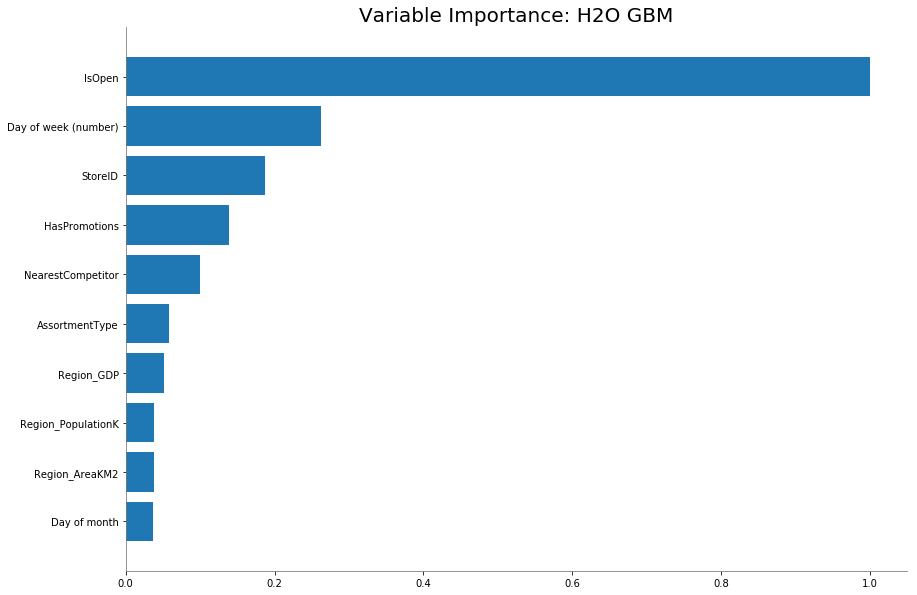

In [17]:
ModelPath= "C:/Benchmarking/Checkpoints/GBM_grid_1_AutoML_20190615_172108_model_1"
Loaded_model = h2o.load_model(ModelPath)
Loaded_model.varimp_plot()

# Size Study: 

In [28]:
df=pd.DataFrame(Loaded_model.get_params())
print('learn_rate:',df.loc['actual_value','learn_rate']) #Defaut=0.1
print('learn_rate_annealing:',df.loc['actual_value','learn_rate_annealing']) #Default=1
print('min_split_improvement:',df.loc['actual_value','min_split_improvement'])
print('distribution:',df.loc['actual_value','distribution'])
print('huber_alpha: ',df.loc['actual_value','huber_alpha'])
df

learn_rate: 0.05
learn_rate_annealing: 1.0
min_split_improvement: 0.0001
distribution: gaussian
huber_alpha:  0.9


,model_id,training_frame,validation_frame,nfolds,keep_cross_validation_models,keep_cross_validation_predictions,keep_cross_validation_fold_assignment,score_each_iteration,score_tree_interval,fold_assignment,...,min_split_improvement,histogram_type,max_abs_leafnode_pred,pred_noise_bandwidth,categorical_encoding,calibrate_model,calibration_frame,custom_metric_func,export_checkpoints_dir,monotone_constraints
__meta,"{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...",...,"{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar...","{'schema_version': 3, 'schema_name': 'ModelPar..."
actual_value,"{'__meta': {'schema_version': 3, 'schema_name'...",None,None,5,False,True,False,False,5,Modulo,...,0.0001,AUTO,1.79769e+308,0,AUTO,False,None,None,C:/Benchmarking/Checkpoints,None
default_value,None,None,None,0,True,False,False,False,0,AUTO,...,1e-05,AUTO,1.79769e+308,0,AUTO,False,None,None,None,None
gridable,False,False,True,False,False,False,False,False,False,True,...,True,True,True,True,True,False,False,False,False,False
help,Destination id for this model; auto-generated ...,Id of the training data frame.,Id of the validation data frame.,Number of folds for K-fold cross-validation (0...,Whether to keep the cross-validation models.,Whether to keep the predictions of the cross-v...,Whether to keep the cross-validation fold assi...,Whether to score during each iteration of mode...,Score the model after every so many trees. Dis...,"Cross-validation fold assignment scheme, if fo...",...,Minimum relative improvement in squared error ...,What type of histogram to use for finding opti...,Maximum absolute value of a leaf node prediction,Bandwidth (sigma) of Gaussian multiplicative n...,Encoding scheme for categorical features,Use Platt Scaling to calculate calibrated clas...,Calibration frame for Platt Scaling,"Reference to custom evaluation function, forma...",Automatically export generated models to this ...,A mapping representing monotonic constraints. ...
is_member_of_frames,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
is_mutually_exclusive_with,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
label,model_id,training_frame,validation_frame,nfolds,keep_cross_validation_models,keep_cross_validation_predictions,keep_cross_validation_fold_assignment,score_each_iteration,score_tree_interval,fold_assignment,...,min_split_improvement,histogram_type,max_abs_leafnode_pred,pred_noise_bandwidth,categorical_encoding,calibrate_model,calibration_frame,custom_metric_func,export_checkpoints_dir,monotone_constraints
level,critical,critical,critical,critical,expert,expert,expert,secondary,secondary,secondary,...,secondary,secondary,expert,expert,secondary,expert,expert,secondary,secondary,secondary
name,model_id,training_frame,validation_frame,nfolds,keep_cross_validation_models,keep_cross_validation_predictions,keep_cross_validation_fold_assignment,score_each_iteration,score_tree_interval,fold_assignment,...,min_split_improvement,histogram_type,max_abs_leafnode_pred,pred_noise_bandwidth,categorical_encoding,calibrate_model,calibration_frame,custom_metric_func,export_

In [89]:
SampleSizes = [20, 30, 40, 50, 60, 70, 80, 90] 
for i in SampleSizes:
    CrossEval(i)

Training data set shape: (20110, 17)
Measured Fit Time:  0.8934476375579834
Using Time Series Cross Validation
 
 
Cross Validation Performance: 
Cross Validation Time: 23.826221
[0.68329983 0.55466659 0.65183528 0.66779217 0.39102993]
EV: 0.589725
[ 976.44519848 1292.50419848 1133.46605205 1044.31633422 1269.88681822]
MAE: 1143.323720
[2070151.61218798 3975607.97450234 2425820.47504332 2393693.14476846
 6059182.7266187 ]
MSE: 3384891.186624
[1438.80214491 1993.89266875 1557.50456662 1547.15647068 2461.54072211]
RMSE: 1839.807378
XV R2 Actuals: [0.66277831 0.55438427 0.65164117 0.66778777 0.39081453]
Cross Validation R2: 0.585481
XVR_fit_time Actuals:  [1.18125725 1.64521885 2.16161036 2.51963973 3.08020592]
XVR_fit_time: 2.117586
score_time Actuals:  [0.87560153 0.87660193 0.85982919 0.8892014  0.87360144]
score_time: 0.874967
 
 
Prediction Time:  0.2184004783630371
 
Validation data set shape: (20405, 17)
Validation Set Explained Variance (EV): 0.67
MAE: 1021.464769
MSE: 1963549.971

Training data set shape: (70387, 17)
Measured Fit Time:  1.912212610244751
Using Time Series Cross Validation
 
 
Cross Validation Performance: 
Cross Validation Time: 23.698446
[0.68329983 0.55466659 0.65183528 0.66779217 0.39102993]
EV: 0.589725
[ 976.44519848 1292.50419848 1133.46605205 1044.31633422 1269.88681822]
MAE: 1143.323720
[2070151.61218798 3975607.97450234 2425820.47504332 2393693.14476846
 6059182.7266187 ]
MSE: 3384891.186624
[1438.80214491 1993.89266875 1557.50456662 1547.15647068 2461.54072211]
RMSE: 1839.807378
XV R2 Actuals: [0.66277831 0.55438427 0.65164117 0.66778777 0.39081453]
Cross Validation R2: 0.585481
XVR_fit_time Actuals:  [1.16980362 1.57860303 2.10600376 2.49700451 3.02880645]
XVR_fit_time: 2.076044
score_time Actuals:  [0.87360168 0.8892014  0.8766017  0.89420176 0.87360168]
score_time: 0.881442
 
 
Prediction Time:  0.2184004783630371
 
Validation data set shape: (20405, 17)
Validation Set Explained Variance (EV): 0.62
MAE: 1132.892700
MSE: 2329374.4672

# Pattern Search:

In [9]:
def PatternSearch(param_dist, PercentToUse=20, Mdl=ExtraTreesRegressor(), alfa=2, verbose=False, metric=2):
    
    class Dimension():
        def __init__(self, value):
            #If value is a Tuple, divide the interval into "length" equaly spaced intervals:
            if isinstance(value,tuple):
               lower=value[0];upper=value[1];length=value[2]
               value=[lower + x*(upper-lower)/(length-1) for x in range(length)]
            self.value=value
            self.value.sort()
            self.min=self.value[0]
            self.max=self.value[-1]
            self.midptidx=int((len(self.value)/2)-0.5)
            self.midpoint=self.value[self.midptidx]
            self.Delta=(len(value)-1)-self.midptidx
            self.BestValue=self.midpoint
            self.CurrIndex=self.midptidx
            self.BestIndex=self.midptidx
        
    Space={}
    BestScore=[]; CurrScore=[]
    for Dkey, Dval in param_dist.items():
        Space[Dkey]=Dimension(Dval)
        print(Dkey,":",Dval)
    
    #Episilon=0.001;
    k=0.5
    xc={}
    #print(Space)
    #builds the first exploratory point by collecting the midpoint of each dimension:
    for Dkey, Dval in Space.items():
        xc[Dkey]=Dval.midpoint
    
    print(xc)    
    BestScore=CrossEval3(trainDataset_X,trainDataset_y,validBench_X,validBench_y,
                                 PercentToUse, Mdl=Mdl,MdlParams=xc,verbose=verbose)
    BestScore=list(BestScore)
    #print("Type BestScore: ",type(BestScore))
    cols=list(xc.keys())
    cols.append('score')
    df=pd.DataFrame(columns=cols)
    xc.update({'score':BestScore[metric]})
    df=df.append(xc, ignore_index=True)
    print(df)

    Ndimensions=len(Space);  
    BestIdx=0; InitialExploration=0

    # i=exploratory moves iterations; k=Overall Iterations
    i=0; Continue=0

    while Continue<3:
        #Exploratory Search:
        while i < Ndimensions:
            k+=1
            for Direction in [1,-1]:
                xn={}; xd={}
                for CurDim in range(0,Ndimensions): #Build the vextor xn:
                    if i == CurDim:
                        NewIndex=list(Space.values())[CurDim].CurrIndex + Direction*list(Space.values())[CurDim].Delta
                        #print(NewIndex)
                        if NewIndex>len(list(Space.values())[CurDim].value)-1: NewIndex=len(list(Space.values())[CurDim].value)-1
                        if NewIndex<0: NewIndex=0
                        xn[list(Space.keys())[CurDim]]=list(Space.values())[CurDim].value[NewIndex]
                    else:
                        xn[list(Space.keys())[CurDim]]=list(Space.values())[CurDim].BestValue
                if list(xn.values()) not in df.drop(['score'], axis=1).values.tolist():
                    #print("Vetor",xn," nao esta em df. Executando Random Forest")
                    print(Direction, xn)            
                    CurrScore=CrossEval3(trainDataset_X,trainDataset_y,validBench_X,validBench_y,
                                                 PercentToUse, Mdl=Mdl,MdlParams=xn,verbose=verbose)
                    #cols=list(xn.keys())
                    #cols.append('score')
                    xd=xn.copy()
                    xd.update({'score':CurrScore[metric]})
                    df=df.append(xd, ignore_index=True)
                    print(df)
                    #print(CurrScore[metric])
                    if CurrScore[metric] > BestScore[metric]: 
                        BestScore[metric]=CurrScore[metric]
                        list(Space.values())[i].BestValue=list(Space.values())[i].value[NewIndex]
                        list(Space.values())[i].BestIndex=NewIndex
                        xc=xn.copy()
                        BestIdx=k
                        break
            list(Space.values())[i].CurrIndex=list(Space.values())[i].BestIndex 
            i+=1

        #xc={}
        #for Dkey, Dval in Space.items():
        #    xc[Dkey]=Dval.BestValue
        #print(xc)

        #pattern move:
        BestIdx=int(BestIdx+0.5)
        pm=df.values[BestIdx]+(df.values[BestIdx]-df.values[InitialExploration])
        pm=pm[0:(len(pm)-1)]
        print("Theoretical Pattern Move: ",pm)

        #picks the closest elements in the lists to the ideal point
        n=0
        for Dkey, Dval in Space.items():
            xn[Dkey]=min(Dval.value, key=lambda x:abs(x-pm[n])) 
            n+=1

        #Evaluates pattern move it it has not been evaluated already:
        if list(xn.values()) not in df.drop(['score'], axis=1).values.tolist():
            print(xn)
            print("Executing Pattern Move...")
            k+=1
            CurrScore=CrossEval3(trainDataset_X,trainDataset_y,validBench_X,validBench_y,
                                 PercentToUse, Mdl=Mdl,MdlParams=xn,verbose=verbose)
            xd=xn.copy()
            xd.update({'score':CurrScore[metric]})
            df=df.append(xd, ignore_index=True)
            print(df)
            if CurrScore[metric] > BestScore[metric]:
                BestScore[metric]=CurrScore[metric]
                xc=xn.copy()
                for CurDim in range(0,Ndimensions):
                    list(Space.values())[CurDim].BestIndex=list(Space.values())[CurDim].value.index(list(xc.values())[CurDim])
                    list(Space.values())[CurDim].CurrIndex=list(Space.values())[CurDim].BestIndex
                    list(Space.values())[CurDim].BestValue=list(xc.values())[CurDim]
                BestIdx=k
                InitialExploration=BestIdx
                BestScore[metric]=CurrScore[metric]
            else:
                #divide delta by 2
                DeltaVector=[]
                for CurDim in range(0,Ndimensions):
                    list(Space.values())[CurDim].Delta=int(0.5+list(Space.values())[CurDim].Delta/alfa)
                    DeltaVector.append(list(Space.values())[CurDim].Delta)
        else:
            #divide delta by 2
            print("Closest point in the Space",xn," has been evaluated")
            DeltaVector=[]
            for CurDim in range(0,Ndimensions):
                list(Space.values())[CurDim].Delta=int(0.5+list(Space.values())[CurDim].Delta/alfa)
                if list(Space.values())[CurDim].Delta==0: list(Space.values())[CurDim].Delta=1
                DeltaVector.append(list(Space.values())[CurDim].Delta)

        print("Current Delta values for each dimension: ",DeltaVector)
        i=0 
        print(Ndimensions)
        if DeltaVector==list(np.ones(len(Space))): Continue+=1

    print("Best Parameters Found:")
    xc=dict(df.loc[df['score'].idxmax()])
    del xc["score"]
    
    Mdl.set_params(**xc)
    print(Mdl.get_params(deep=True))
    print(" ");print(xc);print(" ")
    print(df.loc[df['score'].idxmax()])
    df.sort_values('score', axis=0, ascending=False, inplace=True)
    return df

In [161]:
param_dist={'n_estimators':[4,5,6],
            'max_depth':[4,5,6,10,15,20,30,33]}
PatternSearch(param_dist, 100, alfa=1.4, metric=2)

n_estimators : [4, 5, 6]
max_depth : [4, 5, 6, 10, 15, 20, 30, 33]
{'n_estimators': 5, 'max_depth': 10}
Current Model:  ExtraTreesRegressor
100553
Pandas Value: True
Training data set shape: (100553, 17)
(100553, 17) (100553, 1)
Cross Validation Time: 2.395137
Type BestScore:  <class 'list'>
   n_estimators  max_depth     score
0           5.0       10.0  0.550999
1 {'n_estimators': 6, 'max_depth': 10}
Current Model:  ExtraTreesRegressor
100553
Pandas Value: True
Training data set shape: (100553, 17)
(100553, 17) (100553, 1)
Cross Validation Time: 2.806160
   n_estimators  max_depth     score
0           5.0       10.0  0.550999
1           6.0       10.0  0.557374
1 {'n_estimators': 6, 'max_depth': 33}
Current Model:  ExtraTreesRegressor
100553
Pandas Value: True
Training data set shape: (100553, 17)
(100553, 17) (100553, 1)
Cross Validation Time: 7.112407
   n_estimators  max_depth     score
0           5.0       10.0  0.550999
1           6.0       10.0  0.557374
2           6.0    

n_estimators    6.000000
max_depth       5.000000
score           0.569176
Name: 6, dtype: float64

In [40]:
PercentToUse=100
alfa=2;Episilon=0.001;k=0

class Dimension():
    def __init__(self, value=[]):
        self.value=value
        self.value.sort()
        self.min=self.value[0]
        self.max=self.value[len(value)-1]
        self.midptidx=int((len(self.value)/2)-0.5)
        self.midpoint=self.value[self.midptidx]
        self.Delta=(len(value)-1)-self.midptidx
        self.BestValue=self.midpoint
        self.CurrIndex=self.midptidx
        self.BestIndex=self.midptidx

Space={'n_estimators':Dimension([230,240,250]),
       'max_features':Dimension([2,3]),
       'max_depth':Dimension([16,17,30])}

# Pattern SearchCV Sklearn Style (Hooke-Jeeves Method):

In [6]:
from abc import ABCMeta, abstractmethod
from collections import defaultdict
from collections.abc import Mapping, Sequence, Iterable
from functools import partial, reduce
from itertools import product
import operator
import time
import warnings

import numpy as np
import pandas as pd
from scipy.stats import rankdata

from sklearn.base import BaseEstimator, is_classifier, clone
from sklearn.base import MetaEstimatorMixin
from sklearn.model_selection._split import check_cv
from sklearn.model_selection._validation import _fit_and_score
from sklearn.model_selection._validation import _aggregate_score_dicts
from sklearn.exceptions import NotFittedError
from sklearn.utils._joblib import Parallel, delayed
from sklearn.utils import check_random_state
from sklearn.utils.fixes import MaskedArray
from sklearn.utils.random import sample_without_replacement
from sklearn.utils.validation import indexable, check_is_fitted
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.metrics.scorer import _check_multimetric_scoring
from sklearn.metrics.scorer import check_scoring
from sklearn.model_selection._search import BaseSearchCV 

In [7]:
class PatternSearchCV(BaseSearchCV):
    _required_parameters = ["estimator", "param_distributions"]

    def __init__(self, estimator, param_distributions, scoring=None, #n_iter=10,
                 n_jobs=None, iid='warn', refit=True,
                 cv='warn', verbose=0, pre_dispatch='2*n_jobs',
                 random_state=None, error_score='raise-deprecating',
                 return_train_score=False):
        self.param_distributions = param_distributions
        #self.n_iter = n_iter
        self.random_state = random_state
        super().__init__(
            estimator=estimator, scoring=scoring,
            n_jobs=n_jobs, iid=iid, refit=refit, cv=cv, verbose=verbose,
            pre_dispatch=pre_dispatch, error_score=error_score,
            return_train_score=return_train_score)
        self.ResultDf = pd.DataFrame()

#     param_dist={'n_estimators':[230,240,250],
#            'max_features':[2,3],
#            'max_depth':[16,17,30]}        
        
        class Dimension():
            def __init__(self, value):
                #If value is a Tuple, divide the interval into "length" equaly spaced intervals:
                if isinstance(value,tuple):
                   lower=value[0];upper=value[1];length=value[2]
                   value=[lower + x*(upper-lower)/(length-1) for x in range(length)]
                self.value=value
                self.value.sort()
                self.min=self.value[0]
                self.max=self.value[-1]
                self.midptidx=int((len(self.value)/2)-0.5)
                self.midpoint=self.value[self.midptidx]
                self.Delta=(len(value)-1)-self.midptidx
                self.BestValue=self.midpoint
                self.CurrIndex=self.midptidx
                self.BestIndex=self.midptidx
        
        self.Space={}
        for Dkey, Dval in param_dist.items():
            self.Space[Dkey]=Dimension(Dval)
            print(Dkey,":",Dval) 

    def _run_search(self, evaluate_candidates):
        """Search best parameters using Pattern Search Method"""
        #        PercentToUse=20
        alfa=2; Episilon=0.001; k=0
        Ndimensions=len(self.Space); 

        xc={}; xd={}
        #builds the first exploratory point by collecting the midpoint of each dimension:
        for Dkey, Dval in self.Space.items():
            xc[Dkey]=Dval.midpoint   


        DeltaVector=[]
        for CurDim in range(0,Ndimensions):
            DeltaVector.append(list(self.Space.values())[CurDim].Delta)
        print(" ")
        print("Current Delta values for each dimension: ", DeltaVector)

        BestScore = evaluate_candidates([xc])['mean_test_score'][-1]
        print(" ")
        print(xc)

        cols=list(xc.keys())
        cols.append('score')
        df=pd.DataFrame(columns=cols)
        xd=xc.copy()
        xd.update({'score':BestScore})
        df=df.append(xd, ignore_index=True)
        print(df)

        BestIdx=0; InitialExploration=0

        # i=exploratory moves iterations; k=Overall Iterations
        i=0; Continue=0

        while Continue<3:
            #Exploratory Search:
            while i < Ndimensions:
                k+=1
                for Direction in [1,-1]:
                    xn={}; xd={}
                    for CurDim in range(0,Ndimensions): #Build the vector xn:
                        if i == CurDim:
                            NewIndex=list(self.Space.values())[CurDim].CurrIndex + Direction*list(self.Space.values())[CurDim].Delta
                            #print(NewIndex)
                            if NewIndex>len(list(self.Space.values())[CurDim].value)-1: NewIndex=len(list(self.Space.values())[CurDim].value)-1
                            if NewIndex<0: NewIndex=0
                            xn[list(self.Space.keys())[CurDim]]=list(self.Space.values())[CurDim].value[NewIndex]
                        else:
                            xn[list(self.Space.keys())[CurDim]]=list(self.Space.values())[CurDim].BestValue
                    if list(xn.values()) not in df.drop(['score'], axis=1).values.tolist():
                        #print("Vetor",xn," nao esta em df. Executando Random Forest")
                        print(Direction, xn)            
                        CurrScore = evaluate_candidates([xn])['mean_test_score'][-1]
                        #cols=list(xn.keys())
                        #cols.append('score')
                        xd=xn.copy()
                        xd.update({'score':CurrScore})
                        df=df.append(xd, ignore_index=True)
                        print(df)
                        #print(CurrScore)
                        if CurrScore > BestScore: 
                            BestScore=CurrScore
                            list(self.Space.values())[i].BestValue=list(self.Space.values())[i].value[NewIndex]
                            list(self.Space.values())[i].BestIndex=NewIndex
                            #xc=xn.copy()
                            BestIdx=k-1
                            break
                list(self.Space.values())[i].CurrIndex=list(self.Space.values())[i].BestIndex 
                i+=1

            #pattern move:
            pm=df.values[BestIdx]+(df.values[BestIdx]-df.values[InitialExploration])
            pm=pm[0:(len(pm)-1)]
            print("Theoretical Pattern Move: ",pm)

            #picks the closest elements in the lists to the ideal point
            n=0
            for Dkey, Dval in self.Space.items():
                xn[Dkey]=min(Dval.value, key=lambda x:abs(x-pm[n])) 
                n+=1

            #Evaluates pattern move it it has not been evaluated already:
            if list(xn.values()) not in df.drop(['score'], axis=1).values.tolist():
                print(xn)
                print("Executing Pattern Move...")
                k+=1
                CurrScore = evaluate_candidates([xn])['mean_test_score'][-1]
                xd=xn.copy()
                xd.update({'score':CurrScore})
                df=df.append(xd, ignore_index=True)
                print(df)
                if CurrScore > BestScore:
                    BestScore=CurrScore
                    xc=xn.copy()
                    for CurDim in range(0,Ndimensions):
                        list(self.Space.values())[CurDim].BestIndex=list(self.Space.values())[CurDim].value.index(list(xc.values())[CurDim])
                        list(self.Space.values())[CurDim].CurrIndex=list(self.Space.values())[CurDim].BestIndex
                        list(self.Space.values())[CurDim].BestValue=list(xc.values())[CurDim]
                    BestIdx=k
                    InitialExploration=BestIdx
                    BestScore=CurrScore
                else:
                    #divide delta by 2
                    DeltaVector=[]
                    for CurDim in range(0,Ndimensions):
                        list(self.Space.values())[CurDim].Delta=int(0.5+list(self.Space.values())[CurDim].Delta/alfa)
                        DeltaVector.append(list(self.Space.values())[CurDim].Delta)
            else:
                #divide delta by 2
                print("Nearest Pattern move point",xn," has been evaluated")
                DeltaVector=[]
                for CurDim in range(0,Ndimensions):
                    list(self.Space.values())[CurDim].Delta=int(0.5+list(self.Space.values())[CurDim].Delta/alfa)
                    if list(self.Space.values())[CurDim].Delta==0: list(self.Space.values())[CurDim].Delta=1
                    DeltaVector.append(list(self.Space.values())[CurDim].Delta)

            print("Current Delta values for each dimension: ",DeltaVector)
            i=0 
            if DeltaVector==list(np.ones(Ndimensions)): Continue+=1

        print(" ");print(" ")
        print("Best Parameters Found:")
        print(df.loc[df['score'].idxmax()])
        print(" ");print(" ")
        self.ResultDf=df

In [8]:
#Execute Pattern Search:
import numpy as np
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import RandomizedSearchCV
#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Load data
SplitPercent=20
Nrows,_=trainDataset_X.shape
SplitPoint=int(Nrows*(SplitPercent/100))
X, y = trainDataset_X.iloc[:SplitPoint, :], trainDataset_y.iloc[:SplitPoint]


# build model

clf = ExtraTreesRegressor(n_estimators=240, 
                                 max_features = int(X.columns.size - 15),
                                 max_depth = 16,
                                 n_jobs=-1, 
                                 random_state=0)

# specify parameters and distributions to sample from

#param_dist={'n_estimators':[5,6,7],
#           'max_features':[2,3,4,5]}
           #'n_estimators': list(np.linspace(0, 250, num=26, endpoint=True,dtype=int)+10),
           #'lr':list(np.logspace(-2, -5, num=4, endpoint=True, base=10.0)),
           #'max_depth':list(range(5,18,1))}
            
param_dist={'max_depth':[3,4,5,6,7,8],
            'n_estimators': [47, 48, 49, 50,51,52,53,54,55,57],
            'learning_rate': [0.097,0.098, 0.099,0.1,0.101],
            'colsample_bylevel': [0.49,0.5,0.51,1],
            'colsample_bytree': [0.1,0.25,0.5,0.75,1],
            'gamma': [0,0.1,5,10,20]
           }            


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

from sklearn.model_selection import TimeSeriesSplit
print("Using Time Series Cross Validation")
tscv = TimeSeriesSplit(n_splits=5)
#scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=tscv, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )        


# run randomized search
pattern_search = PatternSearchCV(clf, param_distributions=param_dist,
                                    cv=tscv, n_jobs=-1, verbose=0) 

start = time()
pattern_search.fit(X, y.values.ravel())
print("PatternSearchCV took %.2f seconds " % ((time() - start)))
report(pattern_search.cv_results_)

Using Time Series Cross Validation
max_depth : [3, 4, 5, 6, 7, 8]
n_estimators : [47, 48, 49, 50, 51, 52, 53, 54, 55, 57]
learning_rate : [0.097, 0.098, 0.099, 0.1, 0.101]
colsample_bylevel : [0.49, 0.5, 0.51, 1]
colsample_bytree : [0.1, 0.25, 0.5, 0.75, 1]
gamma : [0, 0.1, 5, 10, 20]
 
Current Delta values for each dimension:  [3, 5, 2, 2, 2, 2]


ValueError: Invalid parameter learning_rate for estimator ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=5,
          max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=-1,
          oob_score=False, random_state=0, verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [56]:
pattern_search.ResultDf

,n_estimators,max_features,score
0,6.0,3.0,0.534920
1,7.0,3.0,0.547069
2,7.0,5.0,0.538547
3,7.0,2.0,0.542613
4,7.0,4.0,0.555353
5,6.0,4.0,0.548891


# Pattern Search Matlab Method:

In [225]:
#Run This cell and then the "#Execute Pattern Search MATLAB:" cell
#Pattern Search MATLAB Style:
class PatternSearchCV(BaseSearchCV):
    _required_parameters = ["estimator", "param_distributions"]

    def __init__(self, estimator, param_distributions, scoring=None, #n_iter=10,
                 n_jobs=None, iid='warn', refit=True,
                 cv='warn', verbose=0, pre_dispatch='2*n_jobs',
                 random_state=None, error_score='raise-deprecating',
                 return_train_score=False):
        self.param_distributions = param_distributions
        #self.n_iter = n_iter
        self.random_state = random_state
        super().__init__(
            estimator=estimator, scoring=scoring,
            n_jobs=n_jobs, iid=iid, refit=refit, cv=cv, verbose=verbose,
            pre_dispatch=pre_dispatch, error_score=error_score,
            return_train_score=return_train_score)
        self.ResultDf = pd.DataFrame()

#     param_dist={'n_estimators':[230,240,250],
#            'max_features':[2,3],
#            'max_depth':[16,17,30]}        
        
        class Dimension():
            def __init__(self, value):
                #If value is a Tuple, divide the interval into "length" equaly spaced intervals:
                if isinstance(value,tuple):
                   lower=value[0];upper=value[1];length=value[2]
                   value=[lower + x*(upper-lower)/(length-1) for x in range(length)]
                self.value=value
                self.value.sort()
                self.min=self.value[0]
                self.max=self.value[-1]
                self.midptidx=int((len(self.value)/2)-0.5)
                self.midpoint=self.value[self.midptidx]
                self.Delta=(len(value)-1)-self.midptidx
                self.BestValue=self.midpoint
                self.CurrIndex=self.midptidx
                self.BestIndex=self.midptidx
        
        self.Space={}
        for Dkey, Dval in param_dist.items():
            self.Space[Dkey]=Dimension(Dval)
            print(Dkey,":",Dval) 

    def _run_search(self, evaluate_candidates):
        """Search best parameters using Pattern Search Method"""
        alfa=2;Episilon=0.001 ;k=0
        Ndimensions=len(self.Space); 

        xc={}; xd={}; xb={}
        #builds the first exploratory point by collecting the midpoint of each dimension:
        for Dkey, Dval in self.Space.items():
            xc[Dkey]=Dval.midpoint   

        for CurDim in range(0,Ndimensions): #divide Delta by 2
            #print("Dividing delta by 2:")
            list(self.Space.values())[CurDim].Delta=int(0.5+list(self.Space.values())[CurDim].Delta/alfa)

        DeltaVector=[]
        for CurDim in range(0,Ndimensions):
            DeltaVector.append(list(self.Space.values())[CurDim].Delta)
        print(" ")
        print("Current Delta values for each dimension: ", DeltaVector)

        #Evaluate the first point as the midpoint of the search space:
        BestScore = evaluate_candidates([xc])['mean_test_score'][-1]
        print(" ")
        print(xc)

        cols=list(xc.keys())
        cols.append('score')
        df=pd.DataFrame(columns=cols)
        xd=xc.copy()
        xd.update({'score':BestScore})
        df=df.append(xd, ignore_index=True)
        print(df)

        BestIdx=0; InitialExploration=0


        # i=exploratory moves iterations; k=Overall Iterations
        i=0; Continue=0

        while Continue<3:
            #Exploratory Search:
            while i < Ndimensions:
                k+=1
                #print("Iteration k:",k)
                print("Dimension: ",i+1)
                for Direction in [1,-1]:
                    xn={}; xd={}
                    for CurDim in range(0,Ndimensions): #Build the vextor xn:
                        if i == CurDim:
                            NewIndex=list(self.Space.values())[CurDim].CurrIndex + Direction*list(self.Space.values())[CurDim].Delta
                            if NewIndex>len(list(self.Space.values())[CurDim].value)-1: NewIndex=len(list(self.Space.values())[CurDim].value)-1
                            if NewIndex<0: NewIndex=0
                            xn[list(self.Space.keys())[CurDim]]=list(self.Space.values())[CurDim].value[NewIndex]
                        else:
                            CurrInd=list(self.Space.values())[CurDim].CurrIndex
                            if CurrInd>len(list(self.Space.values())[CurDim].value)-1: CurrInd=len(list(self.Space.values())[CurDim].value)-1
                            if CurrInd<0: CurrInd =0
                            xn[list(self.Space.keys())[CurDim]]=list(self.Space.values())[CurDim].value[CurrInd]
                    if list(xn.values()) not in df.drop(['score'], axis=1).values.tolist():
                        print(Direction, xn)            
                        CurrScore = evaluate_candidates([xn])['mean_test_score'][-1]
                        #cols=list(xn.keys())
                        #cols.append('score')
                        xd=xn.copy()
                        xd.update({'score':CurrScore})
                        df=df.append(xd, ignore_index=True)
                        print(df)
                        #print(CurrScore)
                        if CurrScore > BestScore: 
                            BestScore=CurrScore
                            list(self.Space.values())[i].BestValue=list(self.Space.values())[i].value[NewIndex]
                            list(self.Space.values())[i].BestIndex=NewIndex
                            xb=xn.copy()
                            BestIdx=k-1

                i+=1
            xd={}    
            NotEqual=False
            for Dkey, Dval in self.Space.items():
                #print(Dval.CurrIndex,Dval.BestIndex)
                if Dval.CurrIndex != Dval.BestIndex: NotEqual=True
            print(" ");print(" ");
            #print("NotEqual =",NotEqual)
            DeltaVector=[]
            if NotEqual:
                for CurDim in range(0,Ndimensions): #update Current index to Best Point:
                    list(self.Space.values())[CurDim].CurrIndex=list(self.Space.values())[CurDim].BestIndex

                print("Best vector so far (xb):",xb) 

                #Multiply delta by 2
                print("multiplying delta by 2:")
                for CurDim in range(0,Ndimensions):
                    list(self.Space.values())[CurDim].Delta=int(0.5+list(self.Space.values())[CurDim].Delta*alfa)
                    DeltaVector.append(list(self.Space.values())[CurDim].Delta)
            else:
                print("Dividing delta by 2:")
                for CurDim in range(0,Ndimensions): #Stay in current point and divide Delta by 2
                    list(self.Space.values())[CurDim].Delta=int(0.5+list(self.Space.values())[CurDim].Delta/alfa)
                    DeltaVector.append(list(self.Space.values())[CurDim].Delta)

            print("Current Delta values for each dimension: ",DeltaVector)
            i=0 
            if DeltaVector==list(np.ones(Ndimensions)): Continue+=1

        print(" ");print(" ")
        print("Best Parameters Found:")
        print(df.loc[df['score'].idxmax()])
        print(" ");print(" ")
        self.ResultDf=df


In [226]:
#Execute Pattern Search MATLAB:
import numpy as np
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import RandomizedSearchCV
#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


      
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# run Pattern search:

def PatternSearchMatLab(param_dist,PercentToUse=20,Mdl=ExtraTreesRegressor()):
    # Load data
    SplitPercent=PercentToUse
    Nrows,_=trainDataset_X.shape
    SplitPoint=int(Nrows*(SplitPercent/100))
    X, y = trainDataset_X.iloc[:SplitPoint, :], trainDataset_y.iloc[:SplitPoint]
    print("Using Time Series Cross Validation")
    tscv = TimeSeriesSplit(n_splits=5)
    #scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=tscv, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )        
    
    pattern_search = PatternSearchCV(Mdl, param_distributions=param_dist,
                                        cv=tscv, n_jobs=-1, verbose=0) 

    start = time()
    pattern_search.fit(X, y.values.ravel())
    print("PatternSearchCV took %.2f seconds " % ((time() - start)))
    report(pattern_search.cv_results_)
    return pattern_search

In [228]:
# specify parameters and distributions to sample from

# build model
# Mdl = ExtraTreesRegressor(n_estimators=240, 
#                                  max_features = int(X.columns.size - 15),
#                                  max_depth = 16,
#                                  n_jobs=-1, 
#                                  random_state=0)
param_dist={'max_depth':[3,4,5,6,7,8],
            'n_estimators': [47, 48, 49, 50,51,52,53,54,55,57],
            'learning_rate': [0.097,0.098, 0.099,0.1,0.101],
            'colsample_bylevel': [0.49,0.5,0.51,1],
            'colsample_bytree': [0.1,0.25,0.5,0.75,1],
            'gamma': [0,0.1,5,10,20]
           } 

Mdl=xgb.XGBRegressor(random_state=0, n_jobs=-1)
#PatternSearch(param_dist, 20, Mdl=Mdl, alfa=1.45, metric=6, verbose=False)
PatternSearchMatLab(param_dist,100,Mdl=Mdl)

Using Time Series Cross Validation
max_depth : [3, 4, 5, 6, 7, 8]
n_estimators : [47, 48, 49, 50, 51, 52, 53, 54, 55, 57]
learning_rate : [0.097, 0.098, 0.099, 0.1, 0.101]
colsample_bylevel : [0.49, 0.5, 0.51, 1]
colsample_bytree : [0.1, 0.25, 0.5, 0.75, 1]
gamma : [0, 0.1, 5, 10, 20]
 
Current Delta values for each dimension:  [2, 3, 1, 1, 1, 1]
 
{'max_depth': 5, 'n_estimators': 51, 'learning_rate': 0.099, 'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'gamma': 5}
   max_depth  n_estimators  learning_rate  colsample_bylevel  \
0        5.0          51.0          0.099                0.5   

   colsample_bytree  gamma     score  
0               0.5    5.0  0.559353  
Dimension:  1
1 {'max_depth': 7, 'n_estimators': 51, 'learning_rate': 0.099, 'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'gamma': 5}
   max_depth  n_estimators  learning_rate  colsample_bylevel  \
0        5.0          51.0          0.099                0.5   
1        7.0          51.0          0.099         

9              0.75    5.0  0.543442  
-1 {'max_depth': 5, 'n_estimators': 51, 'learning_rate': 0.099, 'colsample_bylevel': 0.5, 'colsample_bytree': 0.25, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   

    colsample_bytree  gamma     score  
0           

14              0.50    5.0  0.551587  
Dimension:  2
-1 {'max_depth': 5, 'n_estimators': 47, 'learning_rate': 0.099, 'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.

18              0.50    5.0  0.575505  
-1 {'max_depth': 5, 'n_estimators': 48, 'learning_rate': 0.099, 'colsample_bylevel': 0.49, 'colsample_bytree': 0.5, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099          

22              0.50   20.0  0.561159  
-1 {'max_depth': 5, 'n_estimators': 48, 'learning_rate': 0.099, 'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'gamma': 0}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099           

25              0.50    5.0  0.575677  
Dimension:  2
1 {'max_depth': 5, 'n_estimators': 57, 'learning_rate': 0.099, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099

28              0.50    5.0  0.563909  
-1 {'max_depth': 5, 'n_estimators': 47, 'learning_rate': 0.097, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099             

31              1.00    5.0  0.549812  
-1 {'max_depth': 5, 'n_estimators': 47, 'learning_rate': 0.099, 'colsample_bylevel': 1, 'colsample_bytree': 0.1, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099             

34              0.50    0.0  0.576045  
 
 
Best vector so far (xb): {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.099, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 5}
multiplying delta by 2:
Current Delta values for each dimension:  [16, 24, 8, 8, 8, 8]
Dimension:  1
Dimension:  2
1 {'max_depth': 8, 'n_estimators': 57, 'learning_rate': 0.099, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099        

36              0.50    5.0  0.595450  
-1 {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.097, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099             

38              0.50    5.0  0.534193  
Dimension:  5
1 {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.099, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099  

40              0.10    5.0  0.234621  
Dimension:  6
1 {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.099, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 20}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.09

42              0.50    0.0  0.593296  
 
 
Best vector so far (xb): {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 5}
multiplying delta by 2:
Current Delta values for each dimension:  [32, 48, 16, 16, 16, 16]
Dimension:  1
-1 {'max_depth': 3, 'n_estimators': 47, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.

44              0.50    5.0  0.592783  
Dimension:  3
Dimension:  4
-1 {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.101, 'colsample_bylevel': 0.49, 'colsample_bytree': 0.5, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          5

46              1.00    5.0  0.510440  
-1 {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.1, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099             

48              0.50   20.0  0.595450  
-1 {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 0}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099             

50              0.50    5.0  0.584368  
Dimension:  2
1 {'max_depth': 8, 'n_estimators': 53, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099

52              0.50    5.0  0.553430  
Dimension:  5
Dimension:  6
 
 
Dividing delta by 2:
Current Delta values for each dimension:  [2, 3, 1, 1, 1, 1]
Dimension:  1
-1 {'max_depth': 6, 'n_estimators': 47, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               

54              0.50    5.0  0.594732  
Dimension:  3
-1 {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.1, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099 

56              0.50    5.0  0.553430  
Dimension:  5
1 {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.75, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.09

58              0.25    5.0  0.601372  
Dimension:  6
1 {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'gamma': 10}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.09

[61 rows x 7 columns]
 
 
Best vector so far (xb): {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 5}
multiplying delta by 2:
Current Delta values for each dimension:  [4, 6, 2, 2, 2, 2]
Dimension:  1
-1 {'max_depth': 4, 'n_estimators': 47, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0   

[63 rows x 7 columns]
Dimension:  3
-1 {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.099, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099               0

[65 rows x 7 columns]
Dimension:  5
Dimension:  6
1 {'max_depth': 8, 'n_estimators': 47, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 20}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099  

[67 rows x 7 columns]
 
 
Best vector so far (xb): {'max_depth': 8, 'n_estimators': 53, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 5}
multiplying delta by 2:
Current Delta values for each dimension:  [8, 12, 4, 4, 4, 4]
Dimension:  1
-1 {'max_depth': 3, 'n_estimators': 53, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0  

[69 rows x 7 columns]
Dimension:  3
-1 {'max_depth': 8, 'n_estimators': 53, 'learning_rate': 0.097, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099               0

[71 rows x 7 columns]
Dimension:  5
1 {'max_depth': 8, 'n_estimators': 53, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099               0.50 

[73 rows x 7 columns]
Dimension:  6
1 {'max_depth': 8, 'n_estimators': 53, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 20}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099               0

[75 rows x 7 columns]
 
 
Best vector so far (xb): {'max_depth': 8, 'n_estimators': 57, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 5}
multiplying delta by 2:
Current Delta values for each dimension:  [16, 24, 8, 8, 8, 8]
Dimension:  1
-1 {'max_depth': 3, 'n_estimators': 57, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0 

[77 rows x 7 columns]
Dimension:  4
-1 {'max_depth': 8, 'n_estimators': 57, 'learning_rate': 0.101, 'colsample_bylevel': 0.49, 'colsample_bytree': 0.25, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099             

[79 rows x 7 columns]
-1 {'max_depth': 8, 'n_estimators': 57, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.1, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099               0.50   
12      

[81 rows x 7 columns]
-1 {'max_depth': 8, 'n_estimators': 57, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 0}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099               0.50   
12     

[83 rows x 7 columns]
Dimension:  2
-1 {'max_depth': 8, 'n_estimators': 50, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099               0

[85 rows x 7 columns]
Dimension:  4
-1 {'max_depth': 8, 'n_estimators': 57, 'learning_rate': 0.101, 'colsample_bylevel': 0.5, 'colsample_bytree': 0.25, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099              

[87 rows x 7 columns]
Dimension:  6
 
 
Dividing delta by 2:
Current Delta values for each dimension:  [2, 3, 1, 1, 1, 1]
Dimension:  1
-1 {'max_depth': 6, 'n_estimators': 57, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          

[89 rows x 7 columns]
Dimension:  4
-1 {'max_depth': 8, 'n_estimators': 57, 'learning_rate': 0.101, 'colsample_bylevel': 0.51, 'colsample_bytree': 0.25, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099             

[91 rows x 7 columns]
-1 {'max_depth': 8, 'n_estimators': 57, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 0.1}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099               0.50   
12   

[93 rows x 7 columns]
Dimension:  2
-1 {'max_depth': 8, 'n_estimators': 54, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 5}
    max_depth  n_estimators  learning_rate  colsample_bylevel  \
0         5.0          51.0          0.099               0.50   
1         7.0          51.0          0.099               0.50   
2         3.0          51.0          0.099               0.50   
3         5.0          54.0          0.099               0.50   
4         5.0          48.0          0.099               0.50   
5         5.0          51.0          0.100               0.50   
6         5.0          51.0          0.098               0.50   
7         5.0          51.0          0.099               0.51   
8         5.0          51.0          0.099               0.49   
9         5.0          51.0          0.099               0.50   
10        5.0          51.0          0.099               0.50   
11        5.0          51.0          0.099               0

[95 rows x 7 columns]
Dimension:  3
Dimension:  4
Dimension:  5
Dimension:  6
 
 
Dividing delta by 2:
Current Delta values for each dimension:  [1, 1, 1, 1, 1, 1]
Dimension:  1
Dimension:  2
Dimension:  3
Dimension:  4
Dimension:  5
Dimension:  6
 
 
Dividing delta by 2:
Current Delta values for each dimension:  [1, 1, 1, 1, 1, 1]
 
 
Best Parameters Found:
max_depth             8.000000
n_estimators         57.000000
learning_rate         0.101000
colsample_bylevel     1.000000
colsample_bytree      0.250000
gamma                 5.000000
score                 0.610089
Name: 68, dtype: float64
 
 
PatternSearchCV took 750.85 seconds 
Model with rank: 1
Mean validation score: 0.610 (std: 0.051)
Parameters: {'max_depth': 8, 'n_estimators': 57, 'learning_rate': 0.101, 'colsample_bylevel': 1, 'colsample_bytree': 0.25, 'gamma': 5}

Model with rank: 1
Mean validation score: 0.610 (std: 0.051)
Parameters: {'max_depth': 8, 'n_estimators': 57, 'learning_rate': 0.101, 'colsample_bylevel': 1, '

In [ ]:
PatternSearchMatLab.

In [223]:
#Pattern Serch old version:

#len(Space)
#print(list(Space.keys())[0])
#list(Space.values())[0].midpoint

#print(list(Space.values())[0].min)
#print(list(Space.values())[0].midpoint)
#print(list(Space.values())[0].max)
#print(list(Space.values())[0].midptidx)
print(list(Space.values())[0].Delta,list(Space.values())[1].Delta,list(Space.values())[2].Delta)
print(" ");print(" ")

xc={}
#builds the first exploratory point by collecting the midpoint of each dimension:
for Dkey, Dval in Space.items():
    xc[Dkey]=Dval.midpoint
print(xc)    
BestScore,_,_=CrossEval(PercentToUse,xc)
cols=list(xc.keys())
cols.append('score')
df=pd.DataFrame(columns=cols)
xc.update({'score':BestScore})
df=df.append(xc, ignore_index=True)
print(df)

Ndimensions=len(Space);  
BestIdx=0; InitialExploration=0

# i=exploratory moves iterations; k=Overall Iterations
i=0; Continue=0

while Continue<3:
    #Exploratory Search:
    while i < Ndimensions:
        k+=1
        for Direction in [1,-1]:
            xn={}; xd={}
            for CurDim in range(0,Ndimensions): #Build the vextor xn:
                if i == CurDim:
                    NewIndex=list(Space.values())[CurDim].CurrIndex + Direction*list(Space.values())[CurDim].Delta
                    #print(NewIndex)
                    if NewIndex>len(list(Space.values())[CurDim].value)-1: NewIndex=len(list(Space.values())[CurDim].value)-1
                    if NewIndex<0: NewIndex=0
                    xn[list(Space.keys())[CurDim]]=list(Space.values())[CurDim].value[NewIndex]
                else:
                    xn[list(Space.keys())[CurDim]]=list(Space.values())[CurDim].BestValue
            if list(xn.values()) not in df.drop(['score'], axis=1).values.tolist():
                #print("Vetor",xn," nao esta em df. Executando Random Forest")
                print(Direction, xn)            
                CurrScore,_,_=CrossEval(PercentToUse,xn)
                #cols=list(xn.keys())
                #cols.append('score')
                xd=xn.copy()
                xd.update({'score':CurrScore})
                df=df.append(xd, ignore_index=True)
                print(df)
                #print(CurrScore)
                if CurrScore > BestScore: 
                    BestScore=CurrScore
                    list(Space.values())[i].BestValue=list(Space.values())[i].value[NewIndex]
                    list(Space.values())[i].BestIndex=NewIndex
                    xc=xn.copy()
                    BestIdx=k
                    break
        list(Space.values())[i].CurrIndex=list(Space.values())[i].BestIndex 
        i+=1

    #xc={}
    #for Dkey, Dval in Space.items():
    #    xc[Dkey]=Dval.BestValue
    #print(xc)

    #pattern move:
    pm=df.values[BestIdx]+(df.values[BestIdx]-df.values[InitialExploration])
    pm=pm[0:(len(pm)-1)]
    print(pm)

    #picks the closest elements in the lists to the ideal point
    n=0
    for Dkey, Dval in Space.items():
        xn[Dkey]=min(Dval.value, key=lambda x:abs(x-pm[n])) 
        n+=1

    #Evaluates pattern move it it has not been evaluated already:
    if list(xn.values()) not in df.drop(['score'], axis=1).values.tolist():
        print(xn)
        print("Executing Pattern Move...")
        k+=1
        CurrScore,_,_=CrossEval(PercentToUse,xn)
        xd=xn.copy()
        xd.update({'score':CurrScore})
        df=df.append(xd, ignore_index=True)
        print(df)
        if CurrScore > BestScore:
            BestScore=CurrScore
            xc=xn.copy()
            for CurDim in range(0,Ndimensions):
                list(Space.values())[CurDim].BestIndex=list(Space.values())[CurDim].value.index(list(xc.values())[CurDim])
                list(Space.values())[CurDim].CurrIndex=list(Space.values())[CurDim].BestIndex
                list(Space.values())[CurDim].BestValue=list(xc.values())[CurDim]
            BestIdx=k
            InitialExploration=BestIdx
            BestScore=CurrScore
        else:
            #divide delta by 2
            DeltaVector=[]
            for CurDim in range(0,Ndimensions):
                list(Space.values())[CurDim].Delta=int(0.5+list(Space.values())[CurDim].Delta/alfa)
                DeltaVector.append(list(Space.values())[CurDim].Delta)
    else:
        #divide delta by 2
        print("Pattern move point",xn," has been evaluated")
        DeltaVector=[]
        for CurDim in range(0,Ndimensions):
            list(Space.values())[CurDim].Delta=int(0.5+list(Space.values())[CurDim].Delta/alfa)
            if list(Space.values())[CurDim].Delta==0: list(Space.values())[CurDim].Delta=1
            DeltaVector.append(list(Space.values())[CurDim].Delta)

    print(DeltaVector)
    i=0 
    if DeltaVector==list(np.ones(3)): Continue+=1

print("Best Parameters Found:")
df.loc[df['score'].idxmax()]

1 1 1
 
 
{'n_estimators': 240, 'max_features': 2, 'max_depth': 17}
Training data set shape: (100553, 17)
Cross Validation Time: 34.411968
   n_estimators  max_features  max_depth     score
0         240.0           2.0       17.0  0.679917
1 {'n_estimators': 250, 'max_features': 2, 'max_depth': 17}
Training data set shape: (100553, 17)
Cross Validation Time: 33.190898
   n_estimators  max_features  max_depth     score
0         240.0           2.0       17.0  0.679917
1         250.0           2.0       17.0  0.679335
-1 {'n_estimators': 230, 'max_features': 2, 'max_depth': 17}
Training data set shape: (100553, 17)
Cross Validation Time: 31.665811
   n_estimators  max_features  max_depth     score
0         240.0           2.0       17.0  0.679917
1         250.0           2.0       17.0  0.679335
2         230.0           2.0       17.0  0.679552
1 {'n_estimators': 240, 'max_features': 3, 'max_depth': 17}
Training data set shape: (100553, 17)
Cross Validation Time: 33.954942
   n_est

n_estimators    240.000000
max_features      2.000000
max_depth        16.000000
score             0.680345
Name: 5, dtype: float64

In [17]:
k=5
pm=df.values[k]+(df.values[k]-df.values[k-i])
pm=pm[0:3]
n=0
for Dkey, Dval in Space.items():
    xc[Dkey]=min(Dval.value, key=lambda x:abs(x-pm[n])) #picks the closes elements in the lists to the ideal point
    n+=1
print(xc)

{'n_estimators': 240, 'max_features': 2, 'max_depth': 18}


# Sklearn RandomizedSearchCV

In [ ]:
#Randomize Search:
import numpy as np
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import RandomizedSearchCV
#from sklearn.ensemble import RandomForestRegressor

# Load data
X, y = trainDataset_X, trainDataset_y
#del(trainDataset_X, trainDataset_y)

# build model
n_iter_search = 20
clf = GradientBoostingRegressor(verbose=1,
                                loss="ls",
                                n_iter_no_change=3,
                                tol=0.1,
                                random_state=0)

# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {"n_estimators": [31,37], #sp_randint(37),
              "max_depth": [4,5],
              "max_features": [12],
              "min_samples_split": [5,10],
              "min_samples_leaf" : [1,2]
              }

from sklearn.model_selection import TimeSeriesSplit
print("Using Time Series Cross Validation")
tscv = TimeSeriesSplit(n_splits=5)
#scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=tscv, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )        


# run randomized search
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=tscv, n_jobs=-1)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# SKopt Baysian Optimization:

In [5]:
PercentToUse=100
def objective(params):
    print(params)
    keys=['n_estimators','max_features','max_depth']
    xc=dict(zip(keys,params))
    Score,EV,_,_,R2=CrossEval(PercentToUse, xc)
    print(R2)
    return -R2

from skopt import gp_minimize

# Space=[[230,240,250],  #'n_estimators'
#        [2,3], #'max_features'
#        [16,17,30]] #'max_depth'

Space=[[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260],
       [2,3,4],
       [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]]

#gp_minimize requires a minimum of 10 function calls
r=gp_minimize(objective, Space, n_calls=15, random_state=0)

[240, 3, 30]
Training data set shape: (100553, 17)
Cross Validation Time: 63.298620
0.6458001773754825
[250, 3, 17]
Training data set shape: (100553, 17)
Cross Validation Time: 36.172069
0.6741501541783825
[230, 2, 16]
Training data set shape: (100553, 17)
Cross Validation Time: 26.676526
0.6800284818335245
[240, 3, 17]
Training data set shape: (100553, 17)
Cross Validation Time: 32.522860
0.6738686885201622
[240, 3, 17]
Training data set shape: (100553, 17)
Cross Validation Time: 33.090893
0.6738686885201622
[240, 2, 30]
Training data set shape: (100553, 17)
Cross Validation Time: 54.812135
0.6544249628704046
[230, 3, 17]
Training data set shape: (100553, 17)
Cross Validation Time: 32.401853
0.6729350987370989
[250, 3, 30]
Training data set shape: (100553, 17)
Cross Validation Time: 58.195328
0.6467656594479332
[250, 3, 17]
Training data set shape: (100553, 17)
Cross Validation Time: 34.974000
0.6741501541783825
[250, 2, 17]
Training data set shape: (100553, 17)
Cross Validation Time:

In [239]:
print(r.x)
r.fun

[230, 2, 16]


-0.6800284818335245

In [6]:
r.func_vals

array([-0.64580018, -0.67415015, -0.68002848, -0.67386869, -0.67386869,
       -0.65442496, -0.6729351 , -0.64676566, -0.67415015, -0.67933477])

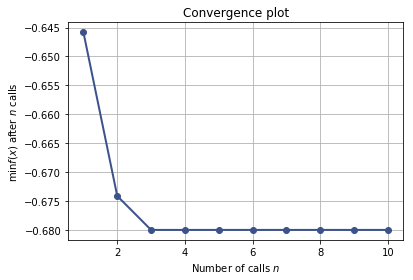

In [12]:
from skopt.plots import plot_convergence
plot_convergence(r) #, yscale="log"

KeyError: 230.25641025641025

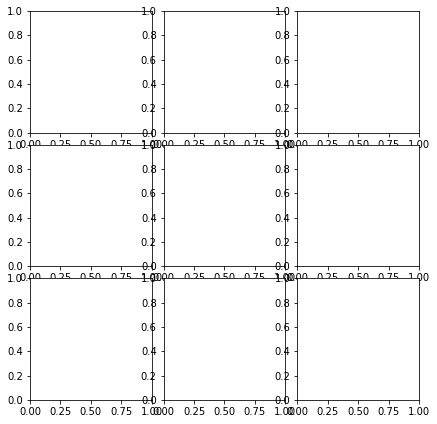

In [241]:
from skopt.plots import plot_objective
plot_objective(r)

# Feature Selector:

## Sklearn.feature_selection RFECV

 
 
Measured Fit Time:  2.8331620693206787
 
 
Model Parameters: 
{'bootstrap': False, 'criterion': 'mse', 'max_depth': 15, 'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
 
 
Feature ranking:
1. feature 6 IsOpen (0.380287)
2. feature 4 HasPromotions (0.155310)
3. feature 2 Day of week (number) (0.104303)
4. feature 13 StoreID (0.045440)
5. feature 11 Region_GDP (0.043561)
6. feature 14 StoreType (0.042415)
7. feature 5 IsHoliday (0.039981)
8. feature 8 NearestCompetitor (0.039229)
9. feature 0 AssortmentType (0.034189)
10. feature 10 Region_AreaKM2 (0.023997)
11. feature 12 Region_PopulationK (0.022469)
12. feature 9 Region (0.019379)
13. feature 3 Day of year (0.013333)
14. feature 1 Day of month (0.012330)
15. feature 15 Week (0.011289)
16. feat

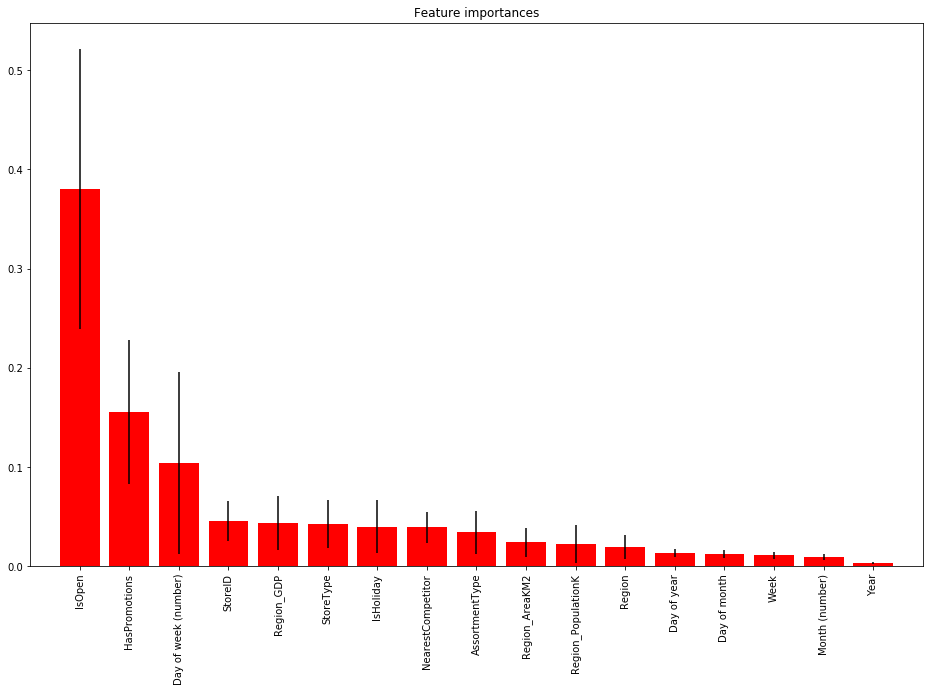

Optimal number of features : 17
Best features : Index(['AssortmentType', 'Day of month', 'Day of week (number)', 'Day of year',
       'HasPromotions', 'IsHoliday', 'IsOpen', 'Month (number)',
       'NearestCompetitor', 'Region', 'Region_AreaKM2', 'Region_GDP',
       'Region_PopulationK', 'StoreID', 'StoreType', 'Week', 'Year'],
      dtype='object')
Original features : Index(['AssortmentType', 'Day of month', 'Day of week (number)', 'Day of year',
       'HasPromotions', 'IsHoliday', 'IsOpen', 'Month (number)',
       'NearestCompetitor', 'Region', 'Region_AreaKM2', 'Region_GDP',
       'Region_PopulationK', 'StoreID', 'StoreType', 'Week', 'Year'],
      dtype='object')


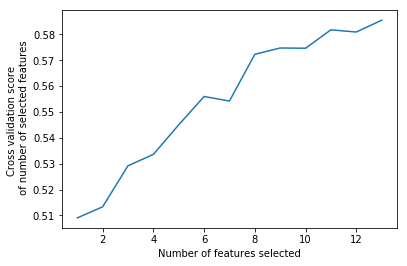

<Figure size 432x288 with 0 Axes>

In [13]:
from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

#forest = RandomForestRegressor(n_estimators=242, n_jobs=-1, random_state=0)
start=time.time()
forest = ExtraTreesRegressor(n_estimators=250, 
                             n_jobs=-1, 
                             max_depth = 15, 
                             max_features = 2,
                             random_state=0)

forest.fit(trainDataset_X, trainDataset_y)
M_FitTime = time.time() - start
print(" ")
print(" ")
print("Measured Fit Time: ", M_FitTime)

UseTScv=True
if UseTScv:
    from sklearn.model_selection import TimeSeriesSplit
    #start=time.time()
    tscv = TimeSeriesSplit(n_splits=5)
    #scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=tscv, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )        
else:
    from sklearn.model_selection import KFold
    #start=time.time()
    kfolds = KFold(n_splits=5,shuffle=False,random_state=0)
    #scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=kfolds, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )
    
#XValidTime = time.time() - start

print(" ")
print(" ")
#print("Cross Validation Performance: ")
#print("Cross Validation Time: %0.2f" % (XValidTime))
#EV=scores['test_explained_variance'].mean()
#print(scores['test_explained_variance'])
#print("EV: %0.2f" % (EV))
##MAE is less sensitive to outliers, The contant value that minimizes the MAE is the median of the target values
#print(-1*scores['test_neg_mean_absolute_error'])
#MAE=-1*scores['test_neg_mean_absolute_error'].mean()
#print("MAE: %0.2f" % (MAE))
##MAE considers outliers, The contant value that minimizes the MSE is the mean of the target values
##If you think your outliers are erros in the data use MAE, if you think the outliers are true datapoints use MSE.
##It is easier to optmize MSE than RMSE because RMSE requires an adjustable learning rate.
#print(-1*scores['test_neg_mean_squared_error'])
#MSE=-1*scores['test_neg_mean_squared_error'].mean()
#print("MSE: %0.2f" % (MSE))
#print(np.sqrt(-1*scores['test_neg_mean_squared_error']))
#RMSE=np.sqrt(-1*scores['test_neg_mean_squared_error'].mean())
#print("RMSE: %0.2f" % (RMSE))
##Optimizing R2 and optimizing for MSE is the same, since R2 = 1-(MSE/Constant)
#print("XV R2 Actuals:",scores['test_r2'])
#R2=scores['test_r2'].mean()
#print("Cross Validation R2: %0.2f" % (R2))
#print("XVR_fit_time Actuals: ", (scores['fit_time']))
#XVR_FT=scores['fit_time'].mean()
#print("XVR_fit_time: %0.2f" % (XVR_FT))
#print("score_time Actuals: ", (scores['score_time']))      
#ST=scores['score_time'].mean()
#print("score_time: %0.2f" % (ST))
Params=forest.get_params(deep=True)
#print(" ")
#print(" ")
print("Model Parameters: ")
print(Params)
print(" ")
print(" ")

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
d=[]
for f in range(trainDataset_X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], trainDataset_X.columns[indices[f]], importances[indices[f]]))
    d.append({'Feature': trainDataset_X.columns[indices[f]]})

from sklearn.feature_selection import RFECV
selector = RFECV(forest, step=1, cv=tscv, min_features_to_select=5,n_jobs=-1,verbose=0)
selector = selector.fit(trainDataset_X, trainDataset_y)
print(selector.support_)
print(selector.ranking_)
print("Optimal number of features : %d" % selector.n_features_)
print("Cross Validation scores:")
print(selector.grid_scores_)

trainDataset_XS=pd.DataFrame(trainDataset_X[trainDataset_X.columns[selector.support_]])
#print(trainDataset_XS.head(3))

FI=[]
importancesS = selector.estimator_.feature_importances_
indicesS = np.argsort(importancesS)[::-1]
for f in range(trainDataset_XS.shape[1]):
    #print("%d. feature %d %s (%f)" % (f + 1, indicesS[f], trainDataset_XS.columns[indicesS[f]], importancesS[indicesS[f]]))
    FI.append({'Rank':f+1, 'Feature':trainDataset_XS.columns[indicesS[f]], 'Importance':importancesS[indicesS[f]]})
	
Feat_Imp = pd.DataFrame(FI)
print(Feat_Imp)
#print(flow_variables)
print(trainDataset_X.shape)
print(trainDataset_XS.shape)

# Plot the feature importances of the forest
plt.figure(figsize=(16,10))
plt.title("Feature importances")
plt.bar(range(trainDataset_X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(trainDataset_X.shape[1]), trainDataset_X.columns[indices],rotation=90)
plt.xlim([-1, trainDataset_X.shape[1]])
plt.show()


print('Optimal number of features :', selector.n_features_)
print('Best features :', trainDataset_X.columns[selector.support_])
print('Original features :', trainDataset_X.columns)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()
plt.savefig('C:\\Benchmarking\\FeatureImportance.png')
output_table = trainDataset_XS.join(trainDataset_y, lsuffix='_X', rsuffix='_y')

## Univariate Feature Selection 
Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator.

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

feature_selection_univariate_model = SelectKBest(mutual_info_regression, k=4)
X_selected_features_univariate = feature_selection_univariate_model.fit_transform(trainDataset_X,trainDataset_y)
print("Reduced data set shape is ",X_selected_features_univariate.shape)

mask = feature_selection_univariate_model.get_support() #list of booleans
print("Selected features = ",data.feature_names[mask])

c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


KeyboardInterrupt: 

## Principal Component Analysis
We now apply principal component analysis. Since we need to decide how many component to select and for this purpose we apply PCA and plot the explained variance ratio and the cumulative explained variance.

In [ ]:
from sklearn.decomposition import PCA
full_pca_model = PCA()
full_fitted_model = full_pca_model.fit(trainDataset_X)
print(full_fitted_model.explained_variance_ratio_)

In [ ]:
plt.semilogy(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,12,1));
plt.xlabel("Features")
plt.ylabel("Cumulative Explained Variance Ratio")

As we can note, four components can actually explain most of the variance in the data so we apply PCA and select the first four components.

In [ ]:
feature_selection_pca_model = PCA(n_components=4)
fitted_model = feature_selection_pca_model.fit(trainDataset_X)

X_selected_features_pca = fitted_model.transform(trainDataset_X)
print("Explained Variance: %s" % fitted_model.explained_variance_ratio_)
print("Reduced data set shape is ", X_selected_features_pca.shape)

# Tests:

In [193]:
LearningRate = [0.14, 0.15, 0.16, 0.13, 0.13]
EvalMetric = ['RMSE','R2']
max_depth= [4,5,7,8]
print(type(LearningRate))
print(len(LearningRate))
print(LearningRate[int((len(LearningRate)/2)-0.5)])
print(LearningRate[0])
print(LearningRate[len(LearningRate)-1])

<class 'list'>
5
0.16
0.14
0.13


In [225]:
from hyperopt import hp

# Create the domain space
#LearningRate = hp.uniform('LearningRate', 0.14, 0.16)
#EvalMetric = hp.choice('EvalMetric',['RMSE','R2','MAE'])
#max_depth=hp.choice('max_depth', [4,5])
#print(type(EvalMetric))
space={'LR': hp.uniform('LearningRate', 0.14, 0.16),
       'EvalMetric': hp.choice('EvalMetric',['RMSE','R2','MAE']),
       'Max_depth': hp.choice('max_depth', [4,5])
      }
from hyperopt.pyll.stochastic import sample
samples=[]
print(type(samples))
for _ in range(5):
    samples.append(sample(space))
print(samples[0])
print(samples[0]['EvalMetric'])

<class 'list'>
{'EvalMetric': 'R2', 'LR': 0.1433033736034484, 'Max_depth': 4}
R2


In [34]:
a={}
?a
a['RMSE']=4
a

{'RMSE': 4}

## Calculate Feature importances and Graph:

Categorical Columns:
Index(['StoreType', 'AssortmentType'], dtype='object')
 
 
Head of Training Data:
   StoreID  IsHoliday  IsOpen  HasPromotions  StoreType  AssortmentType  \
0     1000          0       1              0          0               0   
1     1000          0       1              0          0               0   
2     1000          0       1              0          0               0   

   NearestCompetitor  Region  NumberOfSales  Region_AreaKM2  Region_GDP  \
0                326       7           5676            9643       17130   
1                326       7           8111            9643       17130   
2                326       7           8300            9643       17130   

   Region_PopulationK  Year  Month (number)  Week  Day of year  Day of month  \
0                2770  2016               3    10           61             1   
1                2770  2016               3    10           62             2   
2                2770  2016               3    10      

c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 
 
Measured Fit Time:  1.0066440105438232
Using Time Series Cross Validation
 
 
Cross Validation Performance: 
Cross Validation Time: 8.94
[0.65366408 0.50842293 0.47459996 0.61972558 0.39699894]
EV: 0.53
[1049.49583483 1371.75359231 1321.84140112 1028.53560687 1305.02858933]
MAE: 1215.33
[2457903.34035326 4386336.06559434 3677100.90866691 2740695.37281478
 5999530.01001014]
MSE: 3852313.14
[1567.77018097 2094.35815122 1917.57683253 1655.50456744 2449.3938046 ]
RMSE: 1962.73
XV R2 Actuals: [0.59961468 0.50834681 0.47195162 0.61962855 0.39681197]
Cross Validation R2: 0.52
XVR_fit_time Actuals:  [1.7638638  0.40660071 0.53040123 0.73700309 0.96720171]
XVR_fit_time: 0.88
score_time Actuals:  [0.45340085 0.43680072 0.45240045 0.45240092 0.43780088]
score_time: 0.45
 
 
Converting Validation Categorical Columns to Numbers:
 
 
Head of Validation Data:
   StoreID  IsHoliday  IsOpen  HasPromotions  StoreType  AssortmentType  \
0     1145          0       1              0          0         

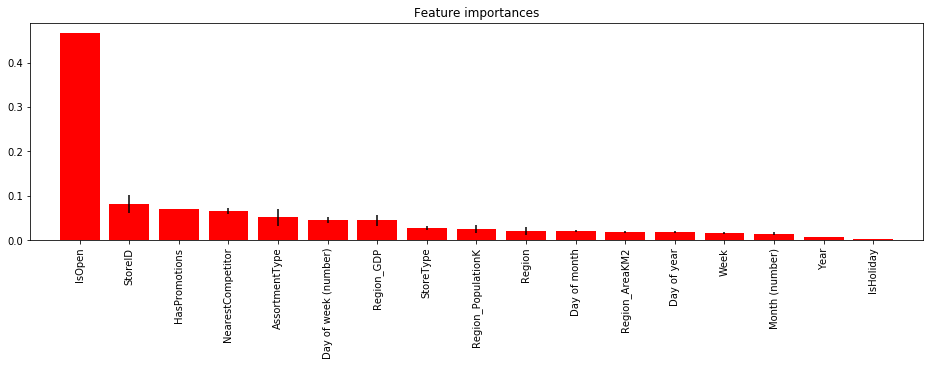

 
Model Parameters:
Win
7
3.6.7
sklearn
0.20.2
['Win', '7', 'Python', '3.6.7', 'sklearn', '0.20.2', 'ExtraTreesRegressor', 1.0066440105438232, 0.8810141086578369, 0.44656076431274416, 8.939087629318237, 0.5306822996170675, 1215.3310048931853, 3852313.1394878863, 1962.731041046604, 0.5192707252591598, 0.10920000076293945, 0.6028330361805241, 1109.069321244793, 2394670.5888502817, 1547.4723224827906, 0.6003824226912086, {'bootstrap': False, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}, [{'1. feat: 6 IsOpen (0.466111)'}, {'2. feat: 13 StoreID (0.081406)'}, {'3. feat: 4 HasPromotions (0.070828)'}, {'4. feat: 8 NearestCompetitor (0.066025)'}, {'5. feat: 0 AssortmentType (0.051350)'}, {'6. feat: 2 Day of week

In [8]:
#Calculate Feature importances and Graph:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print(" ")
print(" ")
print("Feature Importances:")
global d
d=[]
for f in range(trainDataset_X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], trainDataset_X.columns[indices[f]], importances[indices[f]]))
    d.append({"%d. feat: %d %s (%f)" % (f + 1, indices[f], trainDataset_X.columns[indices[f]], importances[indices[f]])})

Feat_Imp = pd.DataFrame(d)

# Plot the feature importances of the forest

plt.figure(figsize=(16,4))
plt.title("Feature importances")
plt.bar(range(trainDataset_X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(trainDataset_X.shape[1]), trainDataset_X.columns[indices],rotation=90)
plt.xlim([-1, trainDataset_X.shape[1]])
plt.show()

print(" ")
print("Model Parameters:")
Params


#InsertHeader()
InsertValues()
print('***Process Completed***')

## Load Train Set:

In [2]:
#Load Train Set:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
import csv
import sys
import gc
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
trainBench = pd.read_csv("c:/Benchmarking/trainBench.csv")
#testBench = pd.read_csv("c:/Benchmarking/testBench.csv")

trainBench = trainBench.drop("ID", axis=1)

cat_columns = trainBench.select_dtypes(['object']).columns
print("Categorical Columns:")
print(cat_columns)
trainBench[cat_columns] = trainBench[cat_columns].astype('category')
cat_columns = trainBench.select_dtypes(['category']).columns
trainBench[cat_columns] = trainBench[cat_columns].apply(lambda x: x.cat.codes)
Int64columns = trainBench.select_dtypes(['int64']).columns
#Int64columns
trainBench[Int64columns] = trainBench[Int64columns].astype(np.int32)
#trainBench.info()
mask = trainBench.columns.difference(['NumberOfSales'])
trainDataset_X = trainBench[mask]
print("Feature Columns:")
print(mask)
trainDataset_y = trainBench['NumberOfSales']
del trainBench
gc

Categorical Columns:
Index(['StoreType', 'AssortmentType'], dtype='object')
Feature Columns:
Index(['AssortmentType', 'Day of month', 'Day of week (number)', 'Day of year',
       'HasPromotions', 'IsHoliday', 'IsOpen', 'Month (number)',
       'NearestCompetitor', 'Region', 'Region_AreaKM2', 'Region_GDP',
       'Region_PopulationK', 'StoreID', 'StoreType', 'Week', 'Year'],
      dtype='object')


## Load Validation Set:

In [ ]:
#Load Validation Set:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

validBench = pd.read_csv("c:/Benchmarking/validBench.csv")
validBench = validBench.drop("ID", axis=1)
#Int64columns = validBench.select_dtypes(['int64']).columns
#Int64columns
validBench[Int64columns] = validBench[Int64columns].astype(np.int32)

print(" ")
print(" ")
print("Converting Validation Categorical Columns to Numbers:")
cat_columns
validBench[cat_columns] = validBench[cat_columns].astype('category')
cat_columns = validBench.select_dtypes(['category']).columns
validBench[cat_columns] = validBench[cat_columns].apply(lambda x: x.cat.codes)
print(" ")
print(" ")
print("Head of Validation Data:")
print(validBench.head(3))
print(" ")
print(mask)
validBench_X = validBench[mask]
validBench_y = validBench['NumberOfSales']

# Time Series Cross Validation:

In [53]:
#Testing Time series cross validation:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)
#scores = cross_validate(forest, trainDataset_X, trainDataset_y, cv=kfolds, scoring=('r2','explained_variance','neg_mean_absolute_error','neg_mean_squared_error') )

X = trainDataset_X
y = trainDataset_y
 
for train_index, test_index in tscv.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   train = X[min(train_index):max(train_index),:]
   test = X[min(test_index):max(test_index),:]
   print(len(train),len(test))

del(train,test)
print(tscv.split(X))

TimeSeriesSplit(max_train_size=None, n_splits=5)
TRAIN: [    0     1     2 ... 16760 16761 16762] TEST: [16763 16764 16765 ... 33518 33519 33520]
16762 16757
TRAIN: [    0     1     2 ... 33518 33519 33520] TEST: [33521 33522 33523 ... 50276 50277 50278]
33520 16757
TRAIN: [    0     1     2 ... 50276 50277 50278] TEST: [50279 50280 50281 ... 67034 67035 67036]
50278 16757
TRAIN: [    0     1     2 ... 67034 67035 67036] TEST: [67037 67038 67039 ... 83792 83793 83794]
67036 16757
TRAIN: [    0     1     2 ... 83792 83793 83794] TEST: [ 83795  83796  83797 ... 100550 100551 100552]
83794 16757
<generator object TimeSeriesSplit.split at 0x00000000341BC888>


In [11]:
trainDataset_X.head(3)

,AssortmentType,Day of month,Day of week (number),Day of year,HasPromotions,IsHoliday,IsOpen,Month (number),NearestCompetitor,Region,Region_AreaKM2,Region_GDP,Region_PopulationK,StoreID,StoreType,Week,Year
0,0,1,3,61,0,0,1,3,326,7,9643,17130,2770,1000,0,10,2016
1,0,2,4,62,0,0,1,3,326,7,9643,17130,2770,1000,0,10,2016
2,0,4,6,64,0,0,1,3,326,7,9643,17130,2770,1000,0,10,2016
